In [1]:
#default_exp verbatims/standard_themes_css

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Verbatims - Standard Themes: CSS

> This module defines the training configuration object, data preparation, training, optimization, and inference code for our multilabel classification task that attempts to predict multiple standard themes at once.

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm
from fastai.text.all import *
from transformers import *

import optuna

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.7
Using transformers 4.3.3


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Training configuration

In [8]:
#export
train_config = {
    'm_pre': '',
    'm_suf': '_multilabel_hf',
    'base_model_name': 'verbatim_standard_theme_css',
    
    'orig_txt_col': 'answer_text',
    'txt_col': '_text_',
    'max_seq_length': 256,
    'batch_size': 8,
    'corpus_suf': '_ans',
    'train_data': STANDARD_THEME_CSS_PATH/'train.csv',
    'valid_data': STANDARD_THEME_CSS_PATH/'test.csv',
    
    'opt_beta': 1, 
    'opt_beta_average': 'weighted',
    'opt_beta_sample_weight': None,
    'opt_start': 0.08, 
    'opt_end': 0.7,
    
    'save_model_monitor': 'precision_score', 
    'save_model_comp': np.greater,
    'learner_path': STANDARD_THEME_CSS_PATH
}

train_config.update({
    'cache_data_path': STANDARD_THEME_CSS_PATH/f"data_{train_config['base_model_name']}.pkl",
    'save_model_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_bestmodel",
    'export_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_export.pkl",
})

In [9]:
train_config

{'m_pre': '',
 'm_suf': '_multilabel_hf',
 'base_model_name': 'verbatim_standard_theme_css',
 'orig_txt_col': 'answer_text',
 'txt_col': '_text_',
 'max_seq_length': 256,
 'batch_size': 8,
 'corpus_suf': '_ans',
 'train_data': Path('data/classification/standard_themes/css/train.csv'),
 'valid_data': Path('data/classification/standard_themes/css/test.csv'),
 'opt_beta': 1,
 'opt_beta_average': 'weighted',
 'opt_beta_sample_weight': None,
 'opt_start': 0.08,
 'opt_end': 0.7,
 'save_model_monitor': 'precision_score',
 'save_model_comp': <ufunc 'greater'>,
 'learner_path': Path('data/classification/standard_themes/css'),
 'cache_data_path': Path('data/classification/standard_themes/css/data_verbatim_standard_theme_css.pkl'),
 'save_model_filename': 'verbatim_standard_theme_css_multilabel_hf_bestmodel',
 'export_filename': 'verbatim_standard_theme_css_multilabel_hf_export.pkl'}

## Data

Prepare the data source

In [10]:
train_df = pd.read_csv(train_config['train_data'])
valid_df = pd.read_csv(train_config['valid_data'])

In [11]:
train_df.head(2)

,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,accessible_to_customers,consistency_in_policies_information,cost_fees,courteous_professional_staff,effective_communications,effectively_uses_websites_online_documentation,helpful_staff,knowledgeable_staff,moving_in_a_positive_direction,overall_satisfaction,process_improvement,provides_effective_advice_guidance,provides_training_on_processes_applications,resolves_problems_effectively,responds_to_requests_within_an_acceptable_time,understands_my_needs_and_requirements
0,602983,38342,"In the past 1-2 years, the office changed their policy to only give international postdocs J1 vi...",NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,454199,ISPO,Let us know your suggestions on how to improve the International Students & Programs Office.,Verbatim-Dept-Improve,636.0,ISPO_Improve,International Students & Programs Office,Student,Global Education,International Program,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,597736,12605,"The custodians are kind and competent people. However, the unit, at least in the research buildi...",NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,454041,Custodial Services,Let us know your suggestions on how to improve Custodial Services.,Verbatim-Dept-Improve,140.0,Custodial_Improve,Custodial Services,Facilities,"Building, Custodial, Facilities Maintenance",Custodial Services,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Remove any rows where the "txt_col" are nan

In [12]:
train_df.dropna(subset=[train_config['orig_txt_col']], inplace=True)
valid_df.dropna(subset=[train_config['orig_txt_col']], inplace=True)

Add a labels column

In [13]:
#hide

# If we want to add a "labels" column with all the labels space delimited (for exmaple, as we would with
# non-encoded labels)
# train_df['labels'] = train_df[STANDARD_THEME_CSS_LABELS].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[STANDARD_THEME_CSS_LABELS].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[STANDARD_THEME_CSS_LABELS].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[STANDARD_THEME_CSS_LABELS].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + STANDARD_THEME_CSS_LABELS].head()

,labels,accessible_to_customers,consistency_in_policies_information,cost_fees,courteous_professional_staff,effective_communications,effectively_uses_websites_online_documentation,helpful_staff,knowledgeable_staff,moving_in_a_positive_direction,overall_satisfaction,process_improvement,provides_effective_advice_guidance,provides_training_on_processes_applications,resolves_problems_effectively,responds_to_requests_within_an_acceptable_time,understands_my_needs_and_requirements
0,consistency_in_policies_information,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,courteous_professional_staff,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,courteous_professional_staff,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,resolves_problems_effectively,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,helpful_staff,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Consolodate datasets and add a standard column for the text data to be trained on

In [14]:
train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])
df[train_config['txt_col']] = df[train_config['orig_txt_col']]

len(df)

3137

In [15]:
#export
def get_train_data(train_config_updates={}, trg_labels=STANDARD_THEME_CSS_LABELS):
    config = {**train_config, **train_config_updates}
    
    train_df = pd.read_csv(config['train_data'])
    train_df.dropna(subset=[config['orig_txt_col']], inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    train_df['labels'] = train_df[trg_labels].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
    train_df['is_valid'] = False
    train_df[train_config['txt_col']] = train_df[train_config['orig_txt_col']]
    
    if ('valid_data' in config and config['valid_data'] is not None):
        valid_df = pd.read_csv(config['valid_data'])
        valid_df.dropna(subset=[config['orig_txt_col']], inplace=True)
        valid_df.reset_index(drop=True, inplace=True)
        valid_df['labels'] = valid_df[trg_labels].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
        valid_df['is_valid'] = True
        valid_df[train_config['txt_col']] = valid_df[train_config['orig_txt_col']]
        
        return pd.concat([train_df, valid_df])
    
    return train_df

In [16]:
df = get_train_data()
test(len(df), 0, operator.ge)

Using the mid-level `DataBlocks` API

In [17]:
#hide
task = HF_TASKS_AUTO.SequenceClassification
pretrained_model_name = "facebook/bart-base" #"roberta-base"

config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_CSS_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [18]:
#hide
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    MultiCategoryBlock(encoded=True, vocab=STANDARD_THEME_CSS_LABELS)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader(train_config['txt_col']), 
                   get_y=ColReader(STANDARD_THEME_CSS_LABELS), 
                   splitter=ColSplitter(col='is_valid'))

In [19]:
#hide
set_seed(TL_RAND_SEED)
dls = dblock.dataloaders(df, bs=train_config['batch_size'], num_workers=0)

In [20]:
#hide
print(f'The Target vocab has ({len(dls.vocab)} items)')

The Target vocab has (16 items)


In [21]:
#hide
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 331]), torch.Size([8, 16]))

In [22]:
#hide
dls.show_batch(dataloaders=dls, max_n=2)

,text,None
0,"Expand Shuttle Services throughout the Greater San Diego area beyond UCSD campus stops. \r\nI recently relocated to San Diego from Seattle, while in Seattle I worked for Microsoft for quite some time. Microsoft has developed a network of shuttles that connects neighborhoods directly to their campuses that run regularly Monday-Friday. San Diego MTS is not optimized to transport people to UCSD's campus so there are obviously many holes. Even once the trolley expansion is complete key neighborhoods will still not have a convenient option to get to UCSD via public transportation. Neighborhood-specific shuttles would help address these issues directly.\r\n\r\nCampus-wide create a mandate for all eligible employees to work from home at least one day a week.\r\nWhen I started with UCSD I was very surprised to find out how far behind UCSD is in terms of letting employees work from home. Having worked in the tech industry in Seattle my previous employer allowed a very flexible schedule, we would work from home as we saw fit, which usually amounted to approx. 2 days a week.\r\nPersonally, for my position at UCSD I could work from home 3-4 days a week joining all meetings via Zoom. The old school mentality of supervisors in my department makes it so my colleagues and I have to suffer through the awful commute to/from campus and pay for parking 5 days a week. I suspect this old school mentality is present in many parts of the campus, which indirectly tells employees that they are not trusted.",process_improvement
1,"The fact that maintenance crews tried to diagnose the symptoms of the problem and not the root of the problems I have requested something to be weary about. I worked in the Math Department and there was a leak coming from the 3rd floor into a 2nd floor storage room. This has resulted into damaged and rusty filing cabinets. \r\n\r\nMy department has placed requests numerous times over this issue over the years and nothing has been resolved. We had determined that it is cracked concrete allowing the water to leak down below from the sanitation machines above that will occasionally leak water. The project needs new resealing of the concrete and flooring on the 3rd floor and instead maintenance has suggested we cover the filing cabinets or ""just wait it out."" This is only treating the symptom and not the root of the problem. The problem was also passed off to 2 other facilities maintenance employees. My impression is there are two out of 4 tickets still open for this issue to this day.\r\n\r\nThe maintenance urgent phone line was very respectable and very friendly. They apologized on behalf of the maintenance workers for the lack of communication/follow-up/work.\r\n\r\nFacilities Maintenance on Campus is well-known to have a poor reputation of communication/responsibility/accountability/responsiveness. Perhaps this is a big reason as to why certain departments take matter into their own hands.",courteous_professional_staff;knowledgeable_staff;resolves_problems_effectively;responds_to_requests_within_an_acceptable_time


Codify building training dls with optional caching

In [23]:
#export
def get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, 
                  vocab=STANDARD_THEME_CSS_LABELS, train_config_updates={}, use_cache=False):
    
    config = {**train_config, **train_config_updates}
    cache_path = config['cache_data_path'] if ('cache_data_path' in config) else None
    
    if (use_cache and cache_path is not None):
        if (os.path.isfile(cache_path)): 
            dls = torch.load(cache_path)
            dls.bs = config['batch_size']
            return dls
    
    blocks = (
        HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=config['max_seq_length']), 
        MultiCategoryBlock(encoded=True, vocab=vocab)
    )

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader(config['txt_col']), 
                       get_y=ColReader(vocab), 
                       splitter=ColSplitter(col='is_valid'))
    
    set_seed(TL_RAND_SEED)
    dls = dblock.dataloaders(df, bs=config['batch_size'], num_workers=0)
    if (cache_path is not None): torch.save(dls, config['cache_data_path'])
        
    return dls

Tests

In [24]:
df = get_train_data()
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model)

test_eq(dls.bs, train_config['batch_size'])
test_eq(len(STANDARD_THEME_CSS_LABELS), len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 2)
test_eq(b[1].shape[1], len(dls.vocab))

In [25]:
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, use_cache=True)

test_eq(dls.bs, train_config['batch_size'])
test_eq(len(STANDARD_THEME_CSS_LABELS), len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 2)
test_eq(b[1].shape[1], len(dls.vocab))

In [26]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,None
0,"Expand Shuttle Services throughout the Greater San Diego area beyond UCSD campus stops. \r\nI recently relocated to San Diego from Seattle, while in Seattle I worked for Microsoft for quite some time. Microsoft has developed a network of shuttles that connects neighborhoods directly to their campuses that run regularly Monday-Friday. San Diego MTS is not optimized to transport people to UCSD's campus so there are obviously many holes. Even once the trolley expansion is complete key neighborhoods will still not have a convenient option to get to UCSD via public transportation. Neighborhood-specific shuttles would help address these issues directly.\r\n\r\nCampus-wide create a mandate for all eligible employees to work from home at least one day a week.\r\nWhen I started with UCSD I was very surprised to find out how far behind UCSD is in terms of letting employees work from home. Having worked in the tech industry in Seattle my previous employer allowed a very flexible schedule, we would work from home as we saw fit, which usually amounted to approx. 2 days a week.\r\nPersonally, for my position at UCSD I could work from home 3-4 days a week joining",process_improvement
1,"Ease of parking is a severely limiting factor in ability to drive into campus. That said, my commute to get to La Jolla is an hour in the morning and 80 minutes in the afternoon. Plainly said: I. am. Driving. You cannot stop that fact when the salaries are so low at UCSD and the cost of living nearby is so high. The only thing is, instead of driving INTO campus, I am driving a mile away from campus and walking or biking in because I cannot afford $86/month to find a parking hunting pass. This impacts parking in the surrounding regions, giving the university a bad rep around town. But congratulations, you successfully added another 30 minutes to my daily commute by forcing me to have to come in from even further away.\r\nThey spent years destroying the vanpool program and finally cut it altogether. The changes they have been making year over year have totally removed the ability of employees to simply take a vanpool. Now you split up several hundred employees into their own separate cars and further externalized the costs of getting to and from work onto them. All while you send bogus emails about how you increased parking spaces by 5% (how much has the campus student/staff population EXPONENTIALLY",cost_fees;overall_satisfaction


## Training

Configure our **metrics**

In [27]:
#export
def get_metrics(train_config_updates={}):
    config = {**train_config, **train_config_updates}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [28]:
#hide
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [29]:
#hide
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [30]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [31]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [32]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [33]:
#export
def get_cbs(train_config_updates={}, add_save_model_cb=True):
    config = {**train_config, **train_config_updates}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    fit_cbs.append(opt_thresh_cb)
    
    return [HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **Learner**

In [34]:
#hide
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [35]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, wd=0.1),
                add_save_model_cb=True, train_config_updates={}):
    
    config = {**train_config, **train_config_updates}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

In [36]:
train_config_updates={'save_model_filename': f"exp_{train_config['save_model_filename']}" }
                      
learn, fit_cbs = get_learner(hf_model, dls, train_df, train_config_updates=train_config_updates)

In [37]:
# learn.blurr_summary()

In [38]:
# learn.show_training_loop()

(0.0033113110810518267, 0.0003311311302240938)

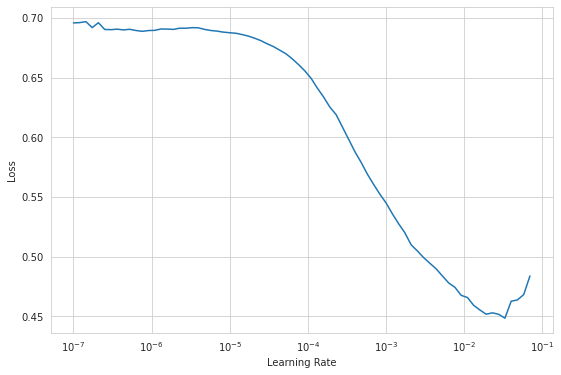

In [39]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [40]:
lr = lr_min; lr_min

0.0033113110810518267

In [41]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(3, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.230020,0.207386,0.921924,0.461995,0.531685,0.520000,0.728043,0.240000,00:31
1,0.187638,0.171289,0.916995,0.541221,0.501459,0.640000,0.779710,0.200000,00:32
2,0.131911,0.143865,0.944598,0.605160,0.645943,0.597500,0.780892,0.380000,00:30


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5316850643866089.
Better model found at epoch 2 with precision_score value: 0.6459427763653247.


(9.999999747378752e-07, 9.12010818865383e-07)

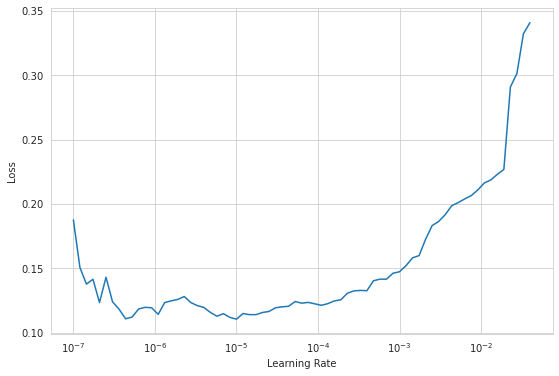

In [42]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [43]:
lr = lr_min; lr_min

9.999999747378752e-07

In [44]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(5, lr_max=slice(lr/10, lr), cbs=fit_cbs)
# learn.fit_one_cycle(5, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.110901,0.143576,0.945386,0.614042,0.646540,0.612500,0.787736,0.370000,00:56
1,0.100562,0.143520,0.944401,0.615349,0.628516,0.625000,0.792440,0.340000,00:56
2,0.124700,0.143110,0.943809,0.615088,0.622010,0.627500,0.792974,0.350000,00:56
3,0.106634,0.143020,0.943809,0.615088,0.622010,0.627500,0.792974,0.350000,00:56
4,0.112776,0.142986,0.944006,0.615838,0.625224,0.627500,0.793086,0.350000,01:00


Better model found at epoch 0 with precision_score value: 0.646540426621375.


In [45]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.34999999999999987

In [46]:
learn.save(f"exp_{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}")

Path('data/classification/standard_themes/css/models/exp_verbatim_standard_theme_css_multilabel_hf.pth')

Look at results

In [47]:
# have to add in the optimize threshold cb since its used as *not* associated to the learner
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]]))); scores

{'valid_loss': 0.1435757875442505,
 'accuracy_multi': 0.9453864097595215,
 'fbeta_score': 0.6140416694162414,
 'precision_score': 0.646540426621375,
 'recall_score': 0.6125,
 'roc_auc_score': 0.7877361532412428,
 'opt_th': 0.3699999999999999}

In [48]:
learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.loss_func.thresh = scores['opt_th']
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Validation Loss: 0.1435757279396057


In [49]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Export model for inference

In [50]:
learn.export(fname=f"exp_{train_config['export_filename']}")

In [51]:
inf_learn = load_learner(f"{train_config['learner_path']}/exp_{train_config['export_filename']}")

In [52]:
inf_learn.loss_func.thresh = scores['opt_th']
inf_learn.loss_func.thresh

0.3699999999999999

In [53]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

[(((#1) ['cost_fees'],),
  (#1) [tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False])],
  (#1) [tensor([0.0045, 0.0029, 0.8629, 0.0016, 0.0040, 0.0014, 0.0063, 0.0039, 0.0017,
        0.1039, 0.0126, 0.0029, 0.0012, 0.0184, 0.0087, 0.0162])])]

In [54]:
inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

[(((#1) ['helpful_staff'],),
  (#1) [tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False])],
  (#1) [tensor([0.0056, 0.0007, 0.0009, 0.0188, 0.0045, 0.0034, 0.5423, 0.0175, 0.0016,
        0.3698, 0.0013, 0.0046, 0.0049, 0.0029, 0.0094, 0.0142])])]

## Review

In [55]:
#hide
try: del learn; del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [56]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config_updates={})

learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.loss_func.thresh = scores['opt_th']
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(torch.Size([317, 16]), torch.Size([317, 16]), 317, 16, 0.3699999999999999)

### Lets look at validation metrics

In [57]:
# determine optimal threshold based on desired f-score
average, sample_weight = train_config['opt_beta_average'], train_config['opt_beta_sample_weight']
    
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [58]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.42000000000000004, 0.37000000000000005, 0.12000000000000001)

In [59]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.6351499445156701, 0.6140416694162414, 0.6843113081193141)

In [60]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.6031389887684666

In [61]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9469637274742126, 0.9453864097595215, 0.9073343873023987)

In [62]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9469637274742126

### Overall metrics

In [63]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, **"Overall, how often is the classifier correct?"**

In [64]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.4637223974763407


In [65]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9469637223974764


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, **"What would the accuracy be by always predicting the most frequent case?"**

In [66]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 4672


In [67]:
most_freq_class_count / len(eval_targs)

0.9211356466876972

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [68]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.6037076453338415


#### Confusion Matrix

Describes the performance of a classification model

In [69]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [70]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

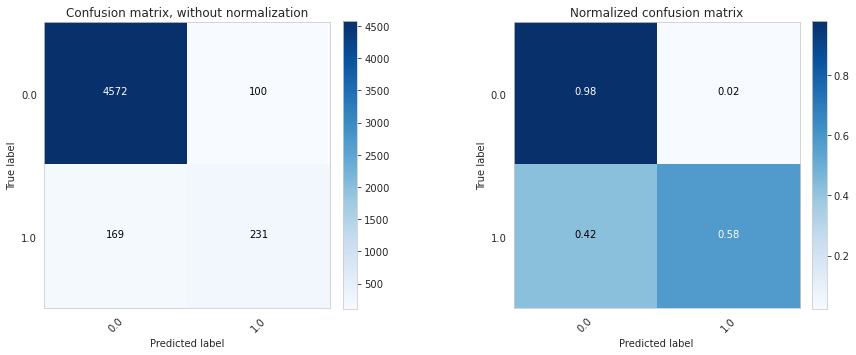

In [71]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [72]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

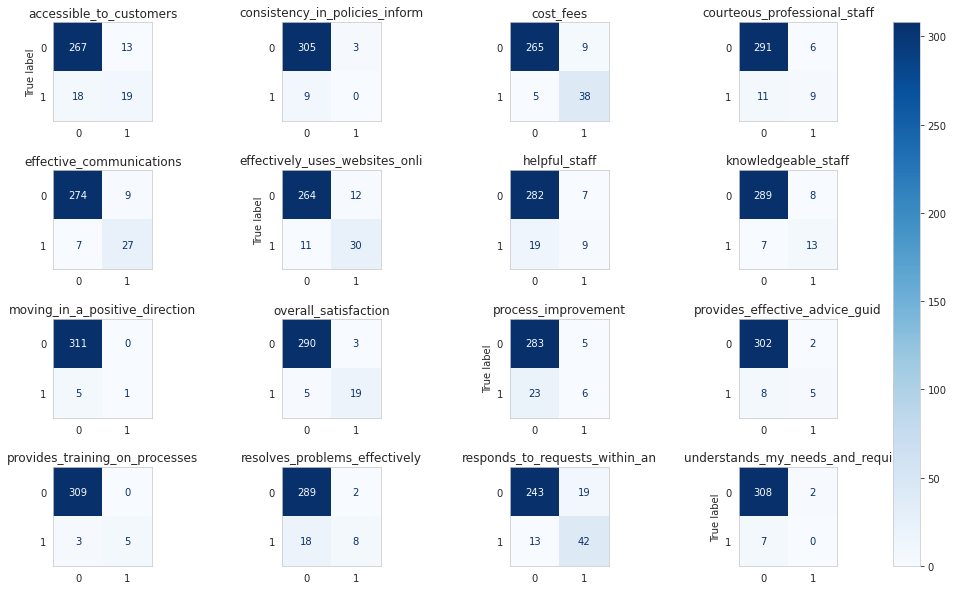

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(4, 4, figsize=(20, 10))
axes = axes.ravel()
for i in range(16):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_CSS_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.5)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [81]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4672
           1       0.70      0.58      0.63       400

    accuracy                           0.95      5072
   macro avg       0.83      0.78      0.80      5072
weighted avg       0.94      0.95      0.94      5072



In [82]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_CSS_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
accessible_to_customers,0.593750,0.513514,0.550725,37.0
consistency_in_policies_information,0.000000,0.000000,0.000000,9.0
cost_fees,0.808511,0.883721,0.844444,43.0
courteous_professional_staff,0.600000,0.450000,0.514286,20.0
effective_communications,0.750000,0.794118,0.771429,34.0
effectively_uses_websites_online_documentation,0.714286,0.731707,0.722892,41.0
helpful_staff,0.562500,0.321429,0.409091,28.0
knowledgeable_staff,0.619048,0.650000,0.634146,20.0
moving_in_a_positive_direction,1.000000,0.166667,0.285714,6.0
overall_satisfaction,0.863636,0.791667,0.826087,24.0


#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [83]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

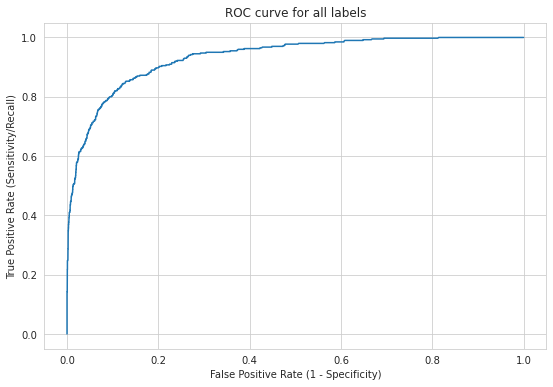

In [84]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [85]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9337430436643835


### Let's look at things by label by label


In [86]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_CSS_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [87]:
# label_metrics

ACCESSIBLE_TO_CUSTOMERS

Null Accuracy:	0.8832807570977917
AUC Score:	0.8767374517374517

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9022082018927445	0.9022082018927445	0.8517350157728707	
Cohen's Kappa:	0.4961804665470393	0.531221676286791	0.49019674935842605	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9368              0.9536              0.9451              280                 
1                   0.5938              0.5135              0.5507              37                  
avg/total           0.7653              0.7335              0.7479              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9462              0.9429              0.9445              280                 
1                   0.5789              0.5946              0.5867       

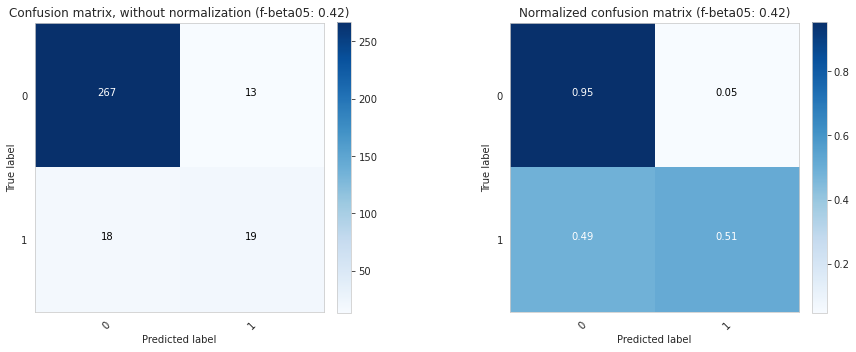

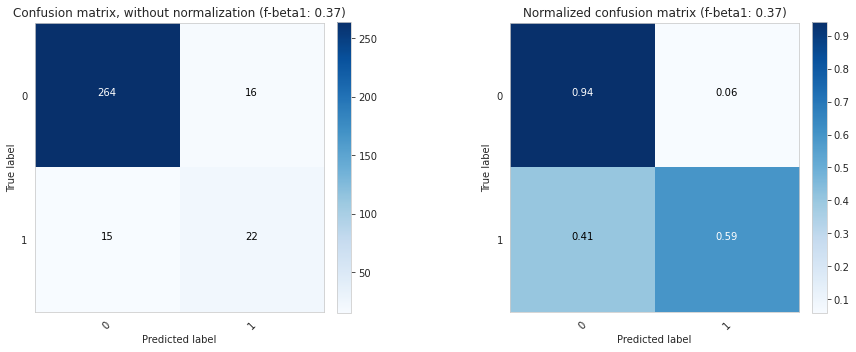

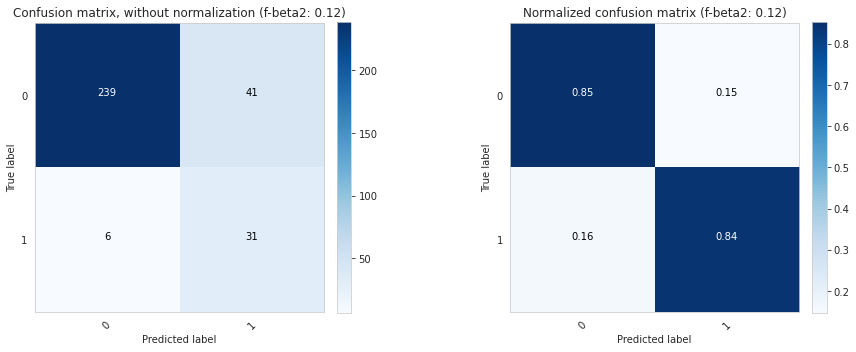



ROC Curve:


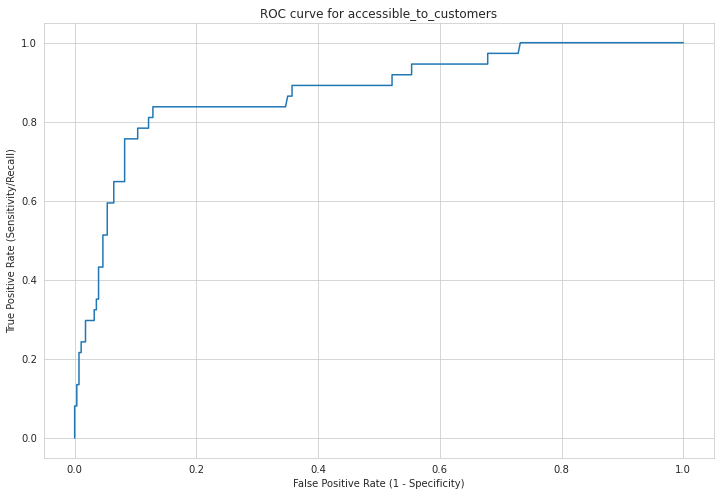

Predicted Probability Distribution:


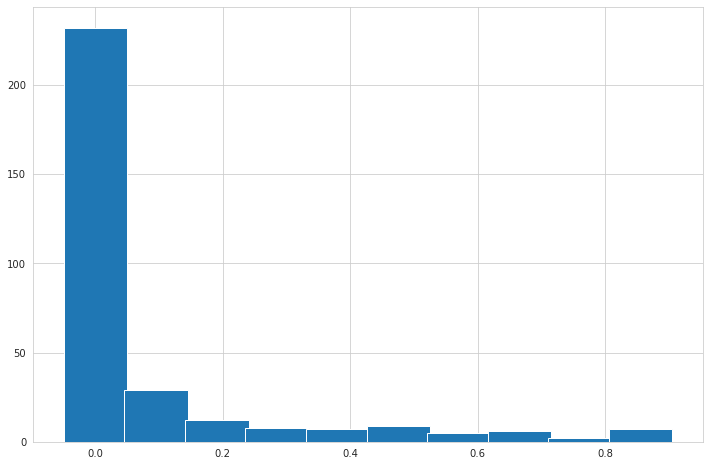



----------------------------------------------------------------------------------------------------


CONSISTENCY_IN_POLICIES_INFORMATION

Null Accuracy:	0.9716088328075709
AUC Score:	0.8650793650793651

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9621451104100947	0.9621451104100947	0.9369085173501577	
Cohen's Kappa:	-0.014399999999999968	-0.014399999999999968	0.201108870967742	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9713              0.9903              0.9807              308                 
1                   0.0                 0.0                 0.0                 9                   
avg/total           0.4857              0.4951              0.4904              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9713              0.9903      

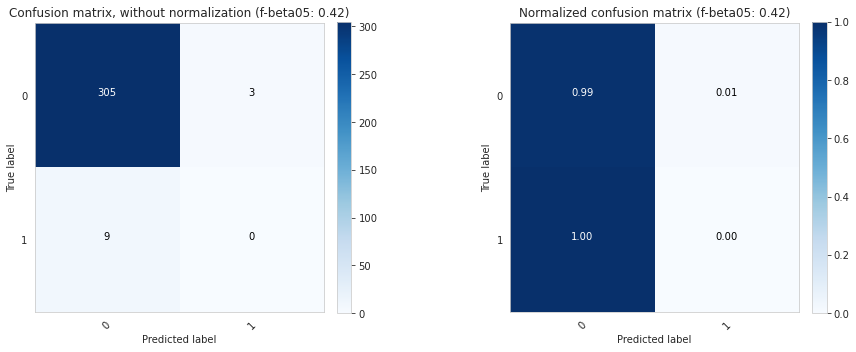

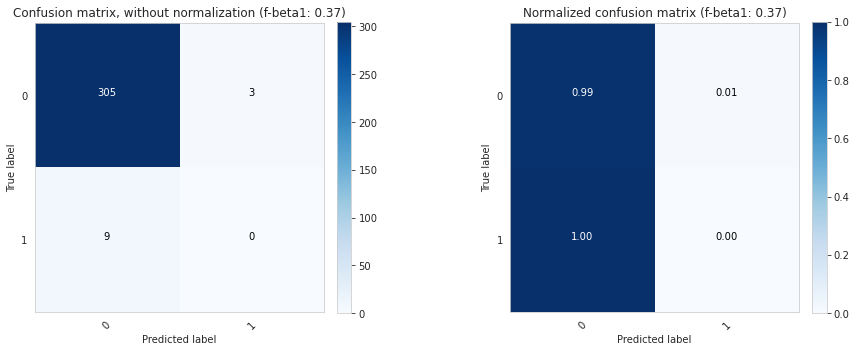

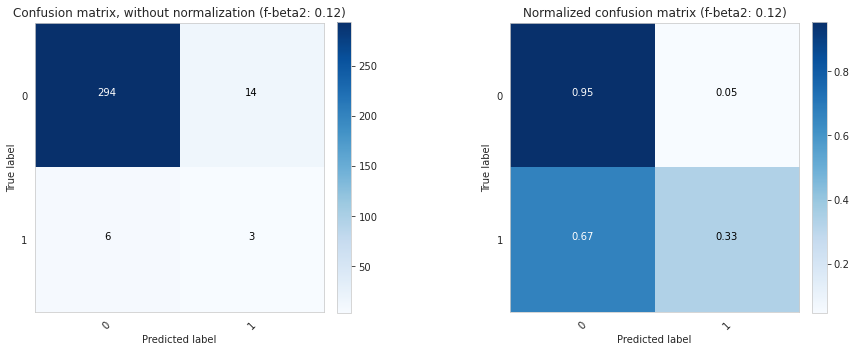



ROC Curve:


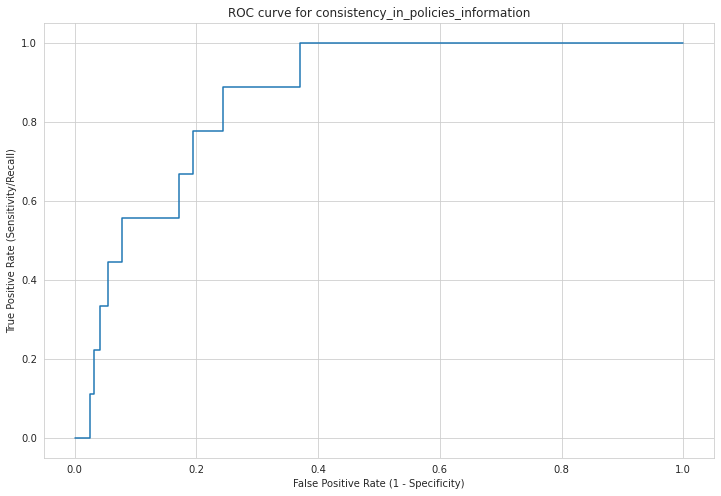

Predicted Probability Distribution:


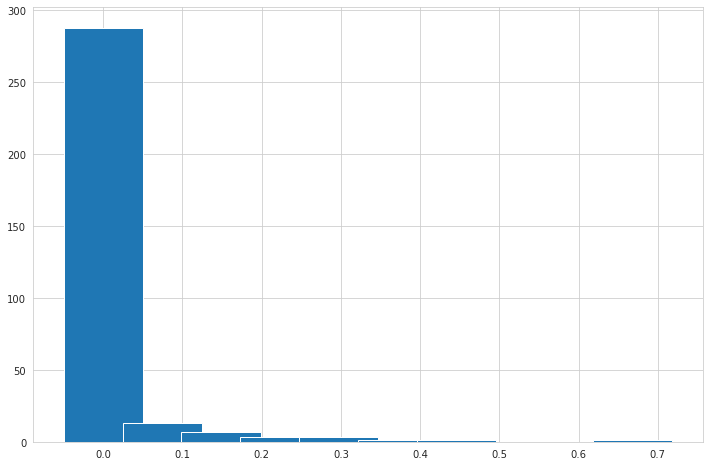



----------------------------------------------------------------------------------------------------


COST_FEES

Null Accuracy:	0.8643533123028391
AUC Score:	0.9799694449159735

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9558359621451105	0.9558359621451105	0.9400630914826499	
Cohen's Kappa:	0.8187683763475988	0.822124248496994	0.7771652669355137	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9815              0.9672              0.9743              274                 
1                   0.8085              0.8837              0.8444              43                  
avg/total           0.895               0.9254              0.9094              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9851              0.9635              0.9742              274 

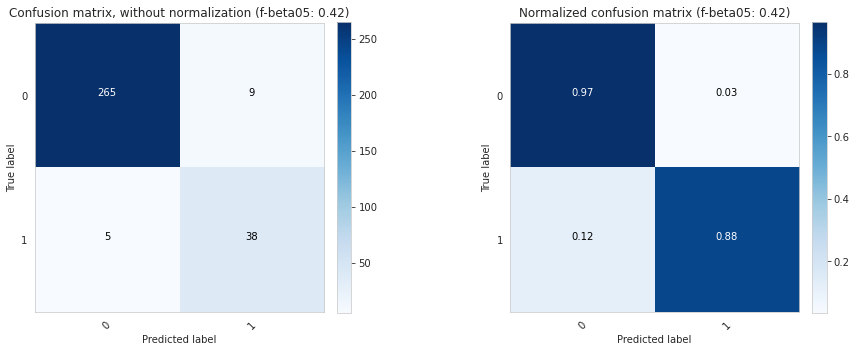

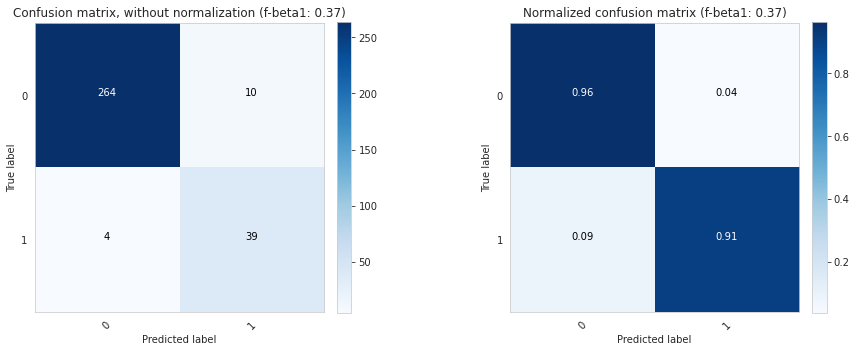

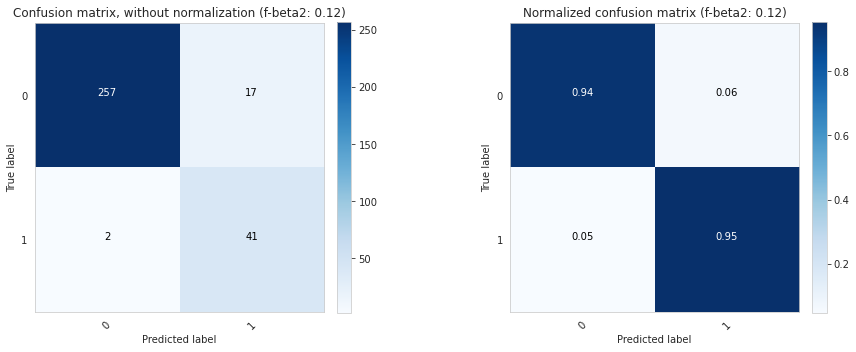



ROC Curve:


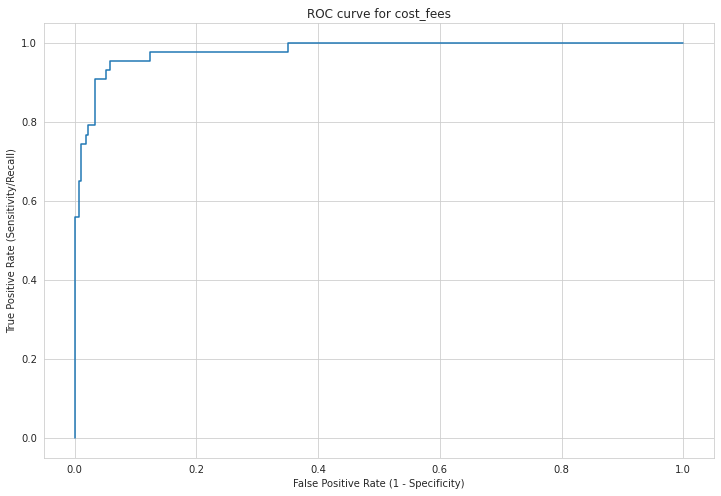

Predicted Probability Distribution:


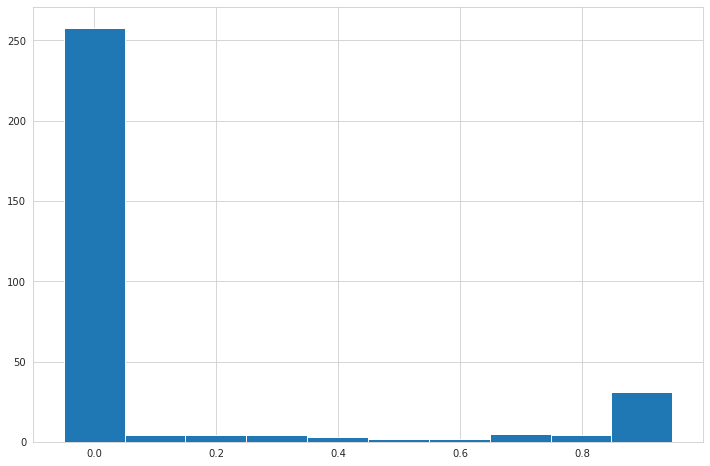



----------------------------------------------------------------------------------------------------


COURTEOUS_PROFESSIONAL_STAFF

Null Accuracy:	0.9369085173501577
AUC Score:	0.9555555555555555

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9463722397476341	0.943217665615142	0.9242902208201893	
Cohen's Kappa:	0.48651738923296806	0.496203425746071	0.5171976139103946	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9636              0.9798              0.9716              297                 
1                   0.6                 0.45                0.5143              20                  
avg/total           0.7818              0.7149              0.743               317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9666              0.9731              0.969

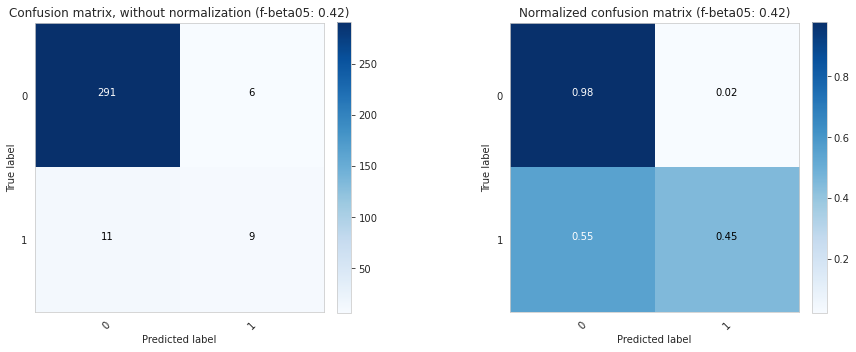

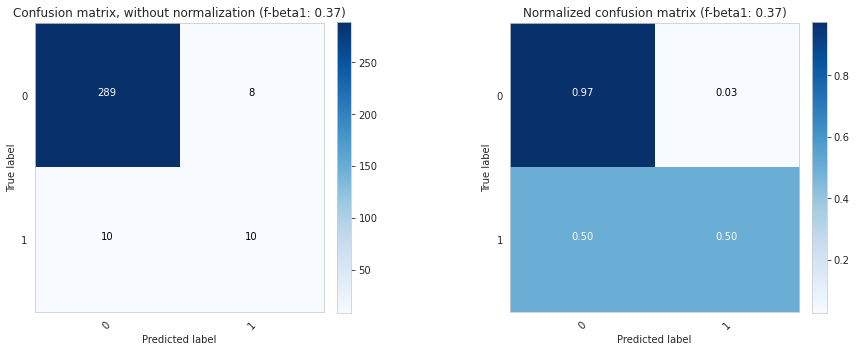

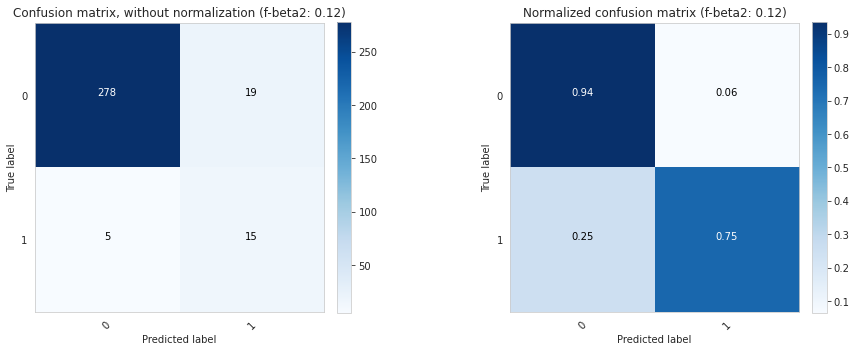



ROC Curve:


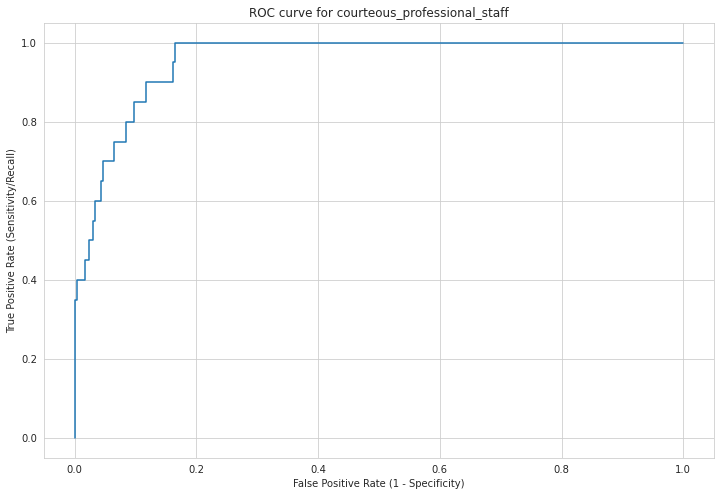

Predicted Probability Distribution:


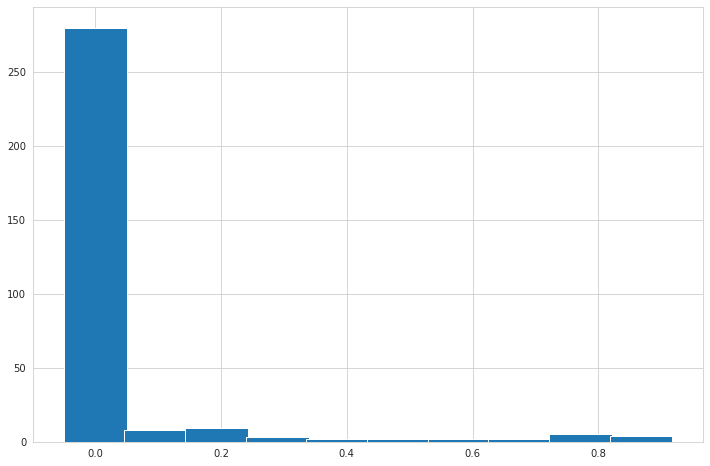



----------------------------------------------------------------------------------------------------


EFFECTIVE_COMMUNICATIONS

Null Accuracy:	0.8927444794952681
AUC Score:	0.934005404281854

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9495268138801262	0.9400630914826499	0.8801261829652997	
Cohen's Kappa:	0.7430858069091277	0.7060373859143931	0.5405096124504121	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9751              0.9682              0.9716              283                 
1                   0.75                0.7941              0.7714              34                  
avg/total           0.8625              0.8812              0.8715              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9748              0.9576              0.9661   

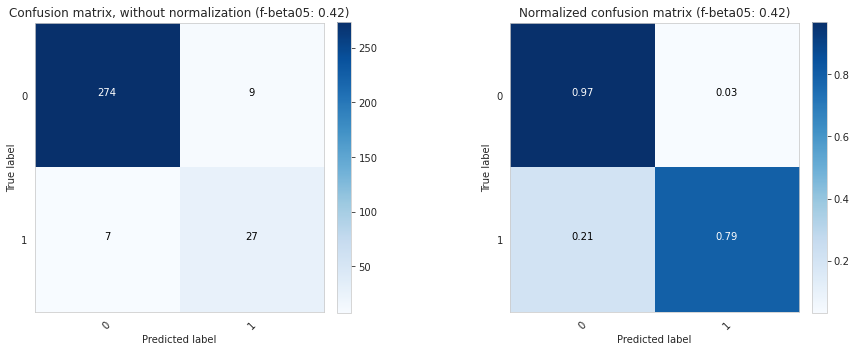

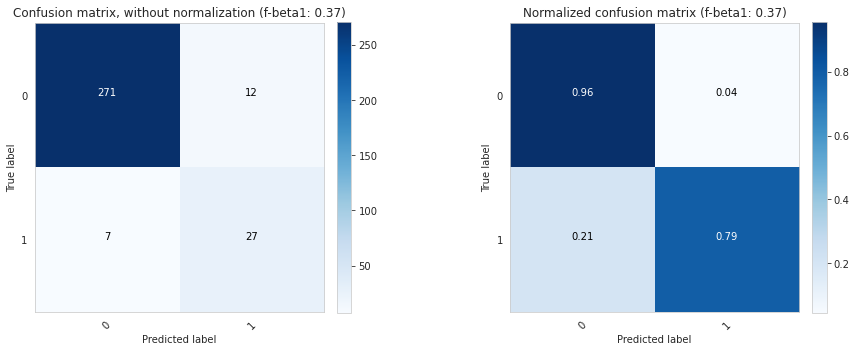

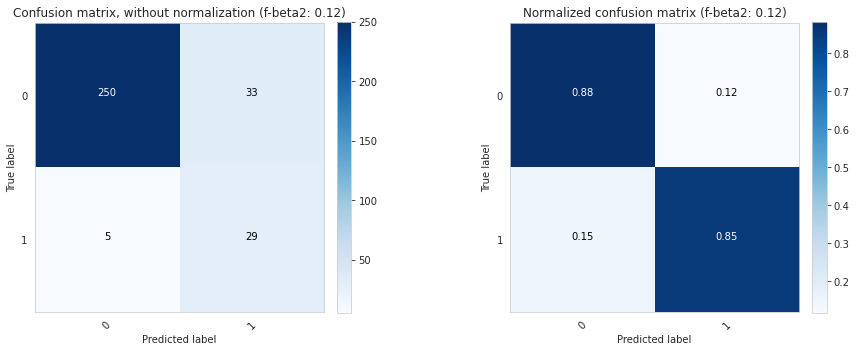



ROC Curve:


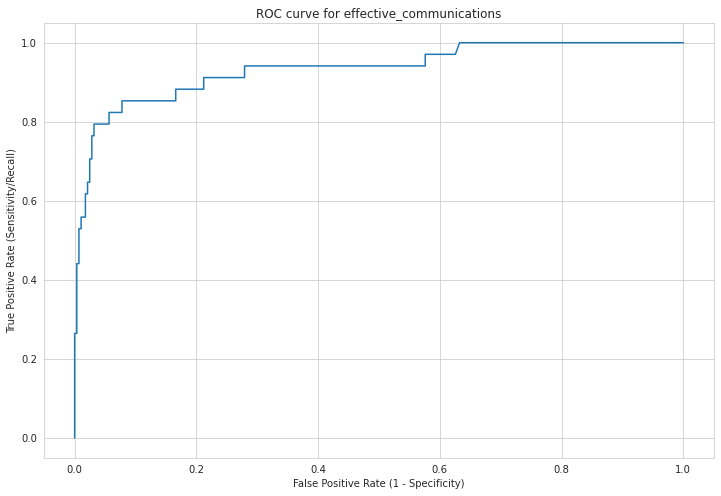

Predicted Probability Distribution:


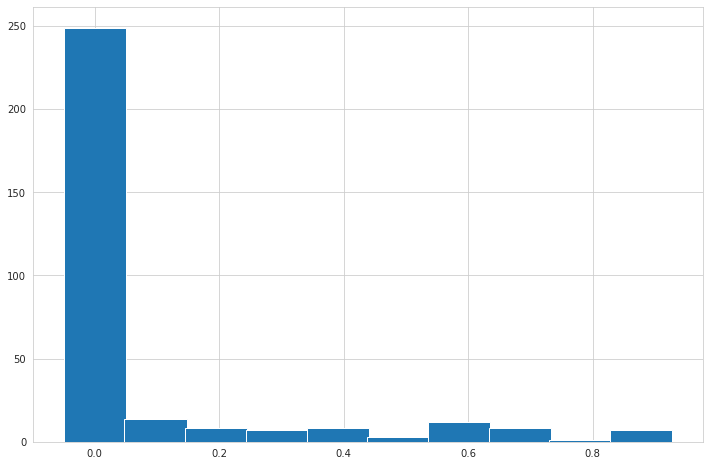



----------------------------------------------------------------------------------------------------


EFFECTIVELY_USES_WEBSITES_ONLINE_DOCUMENTATION

Null Accuracy:	0.8706624605678234
AUC Score:	0.9591286673736302

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9274447949526814	0.9242902208201893	0.9053627760252366	
Cohen's Kappa:	0.6811562513665981	0.6772441880196844	0.6520561978633104	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.96                0.9565              0.9583              276                 
1                   0.7143              0.7317              0.7229              41                  
avg/total           0.8371              0.8441              0.8406              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9632              0.9493

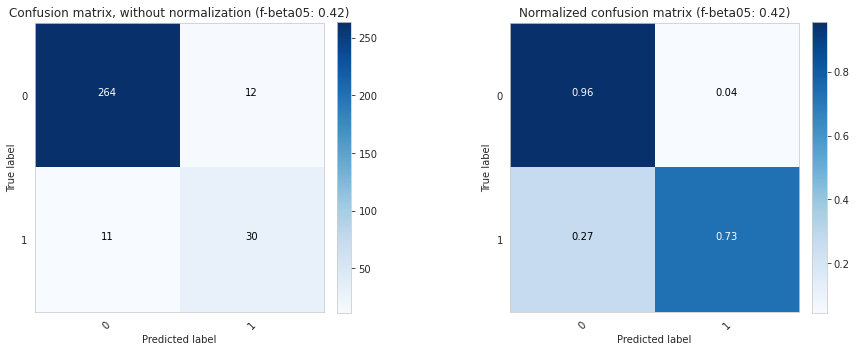

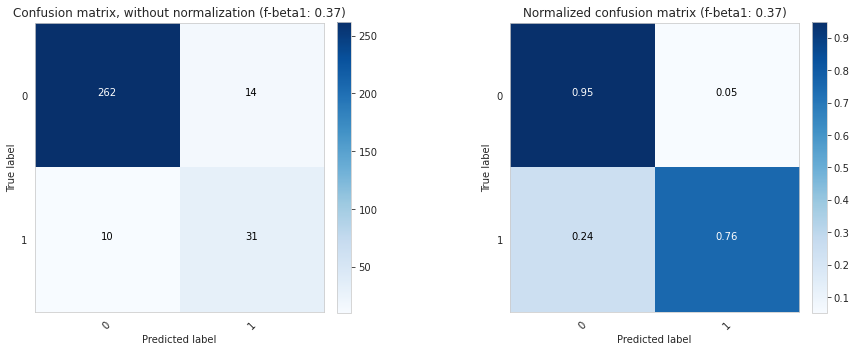

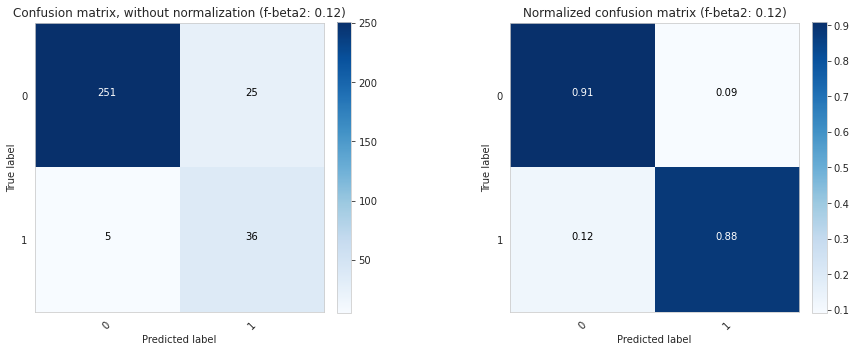



ROC Curve:


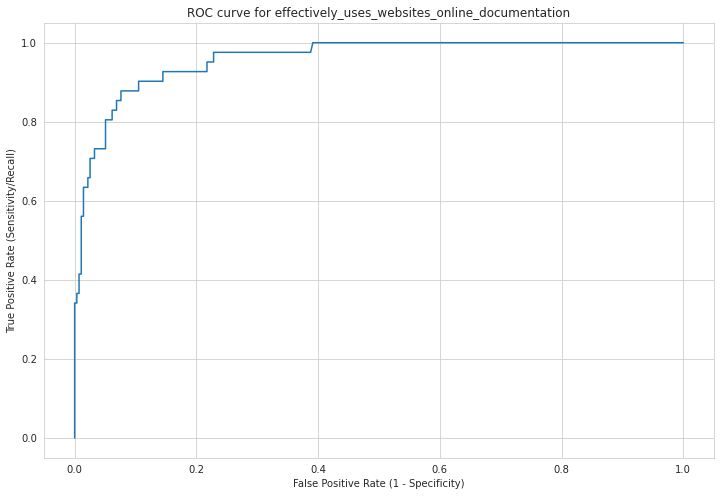

Predicted Probability Distribution:


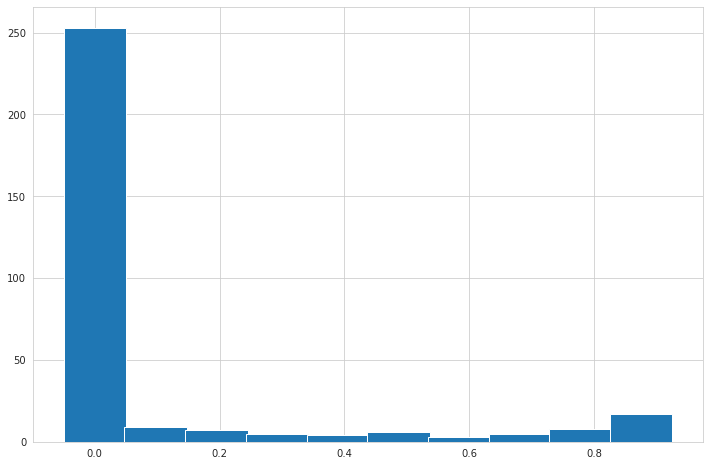



----------------------------------------------------------------------------------------------------


HELPFUL_STAFF

Null Accuracy:	0.9116719242902208
AUC Score:	0.9264087988136431

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.917981072555205	0.9211356466876972	0.8738170347003155	
Cohen's Kappa:	0.36852589641434264	0.4271774485001807	0.4602417844372553	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9369              0.9758              0.9559              289                 
1                   0.5625              0.3214              0.4091              28                  
avg/total           0.7497              0.6486              0.6825              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.943               0.9723              0.9574             

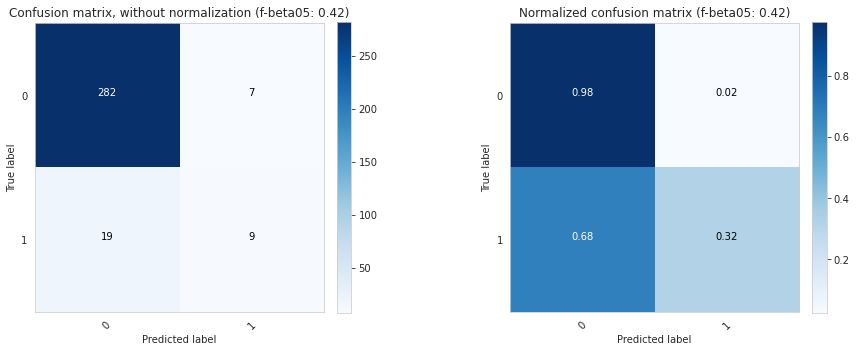

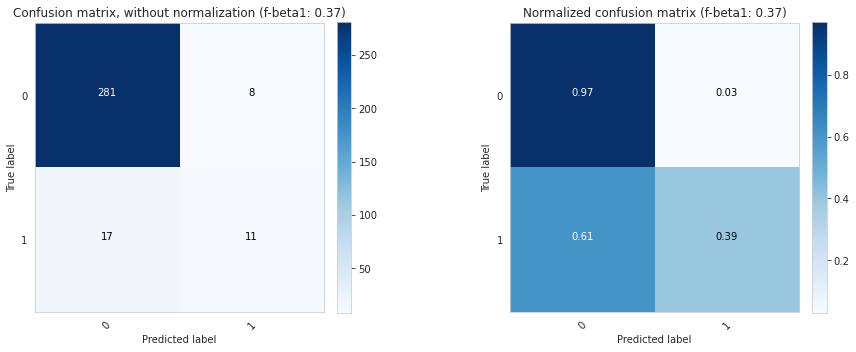

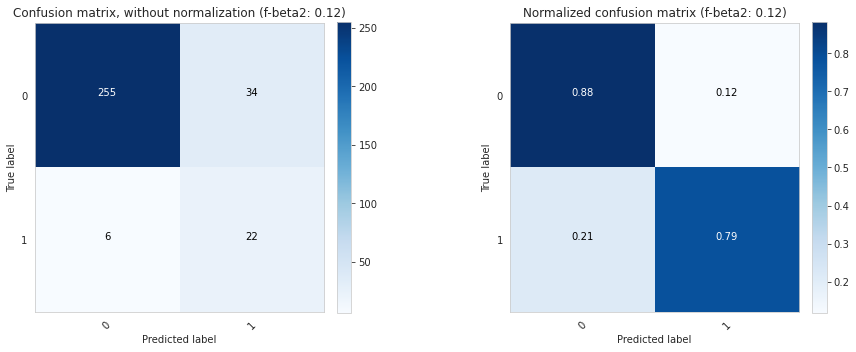



ROC Curve:


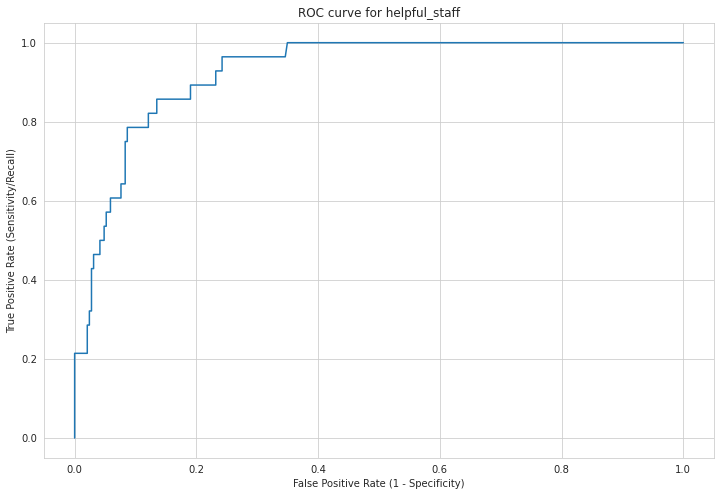

Predicted Probability Distribution:


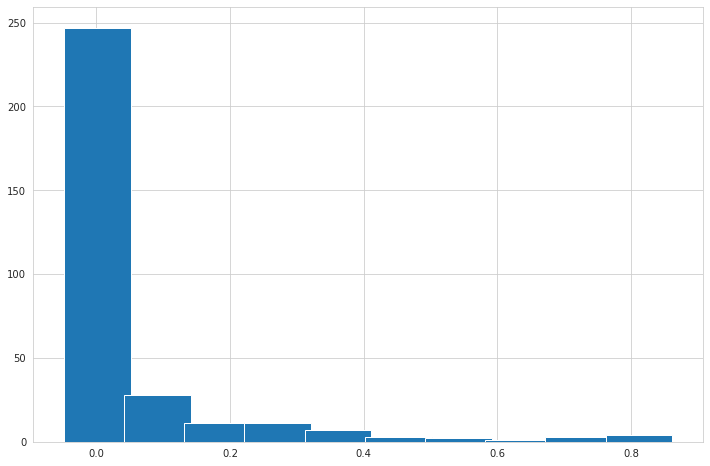



----------------------------------------------------------------------------------------------------


KNOWLEDGEABLE_STAFF

Null Accuracy:	0.9369085173501577
AUC Score:	0.9455387205387206

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9526813880126183	0.9463722397476341	0.9022082018927445	
Cohen's Kappa:	0.6088673192399441	0.5937429325292122	0.4615637499315106	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9764              0.9731              0.9747              297                 
1                   0.619               0.65                0.6341              20                  
avg/total           0.7977              0.8115              0.8044              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9795              0.963               0.9711       

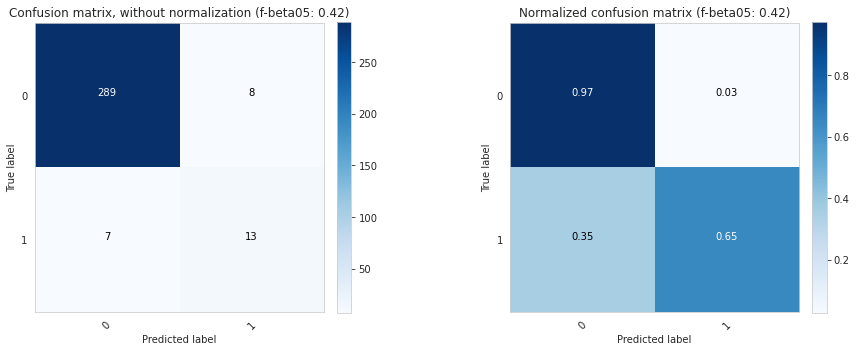

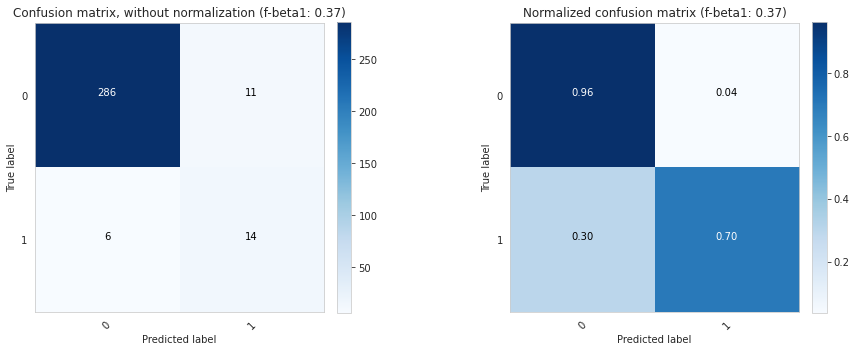

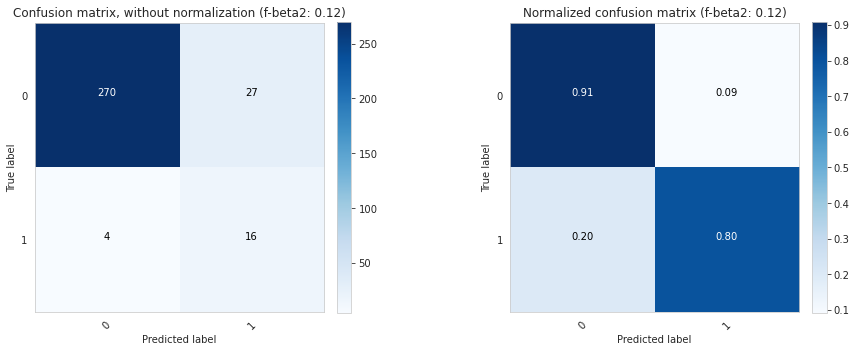



ROC Curve:


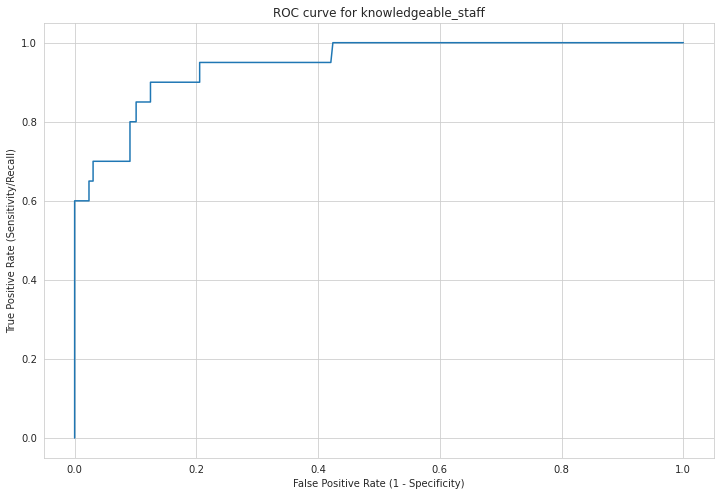

Predicted Probability Distribution:


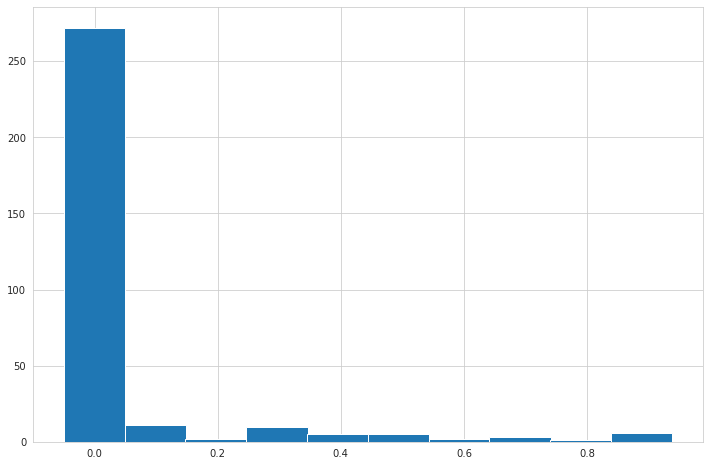



----------------------------------------------------------------------------------------------------


MOVING_IN_A_POSITIVE_DIRECTION

Null Accuracy:	0.9810725552050473
AUC Score:	0.835209003215434

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9842271293375394	0.9842271293375394	0.9779179810725552	
Cohen's Kappa:	0.28183053919347534	0.28183053919347534	0.45033440673767644	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9842              1.0                 0.992               311                 
1                   1.0                 0.1667              0.2857              6                   
avg/total           0.9921              0.5833              0.6389              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9842              1.0                 

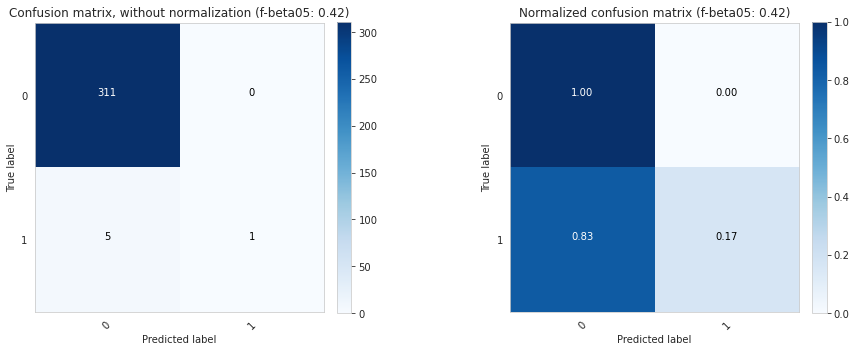

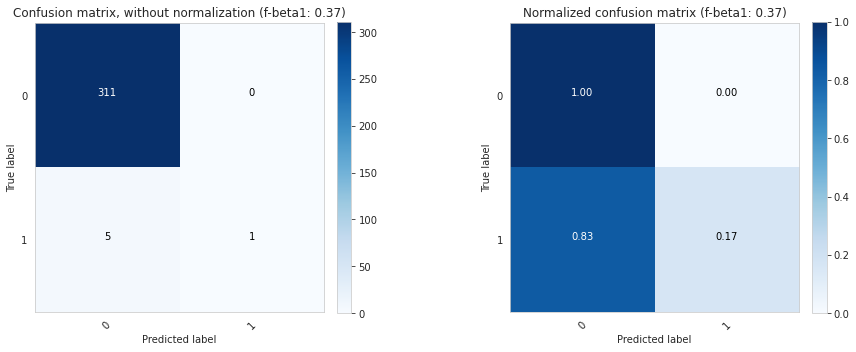

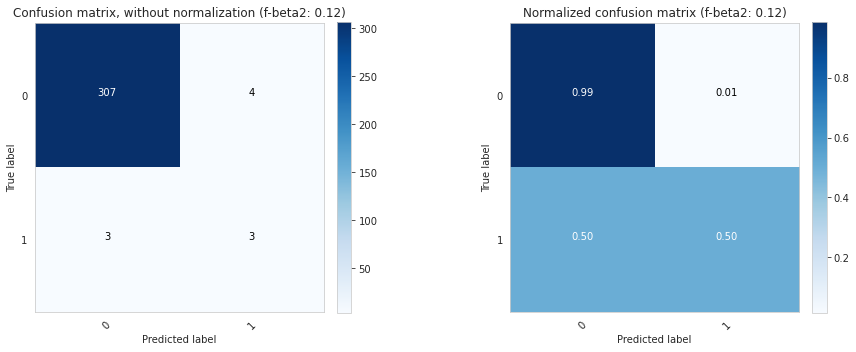



ROC Curve:


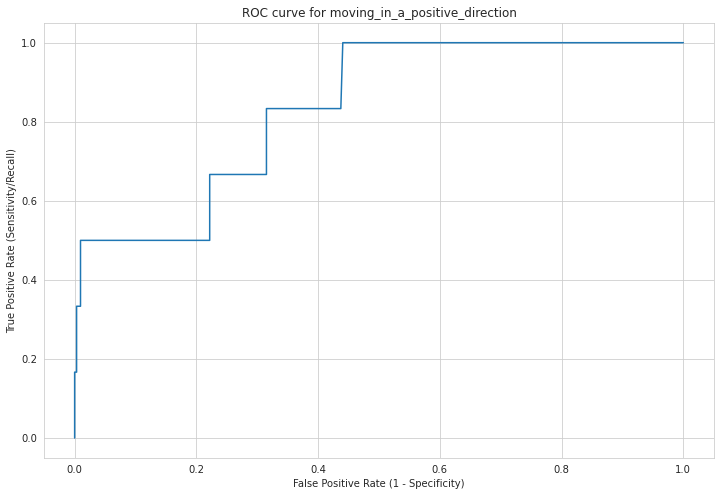

Predicted Probability Distribution:


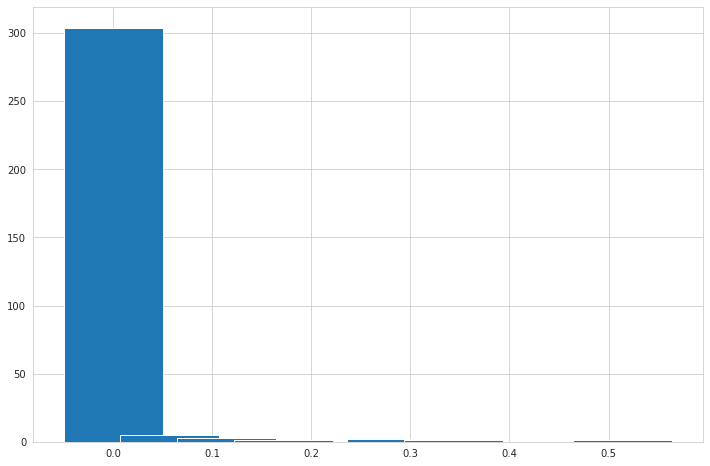



----------------------------------------------------------------------------------------------------


OVERALL_SATISFACTION

Null Accuracy:	0.9242902208201893
AUC Score:	0.9730517633674631

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9747634069400631	0.9747634069400631	0.9337539432176656	
Cohen's Kappa:	0.8125092414608901	0.8125092414608901	0.6209213598314447	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9831              0.9898              0.9864              293                 
1                   0.8636              0.7917              0.8261              24                  
avg/total           0.9233              0.8907              0.9062              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9831              0.9898              0.9864      

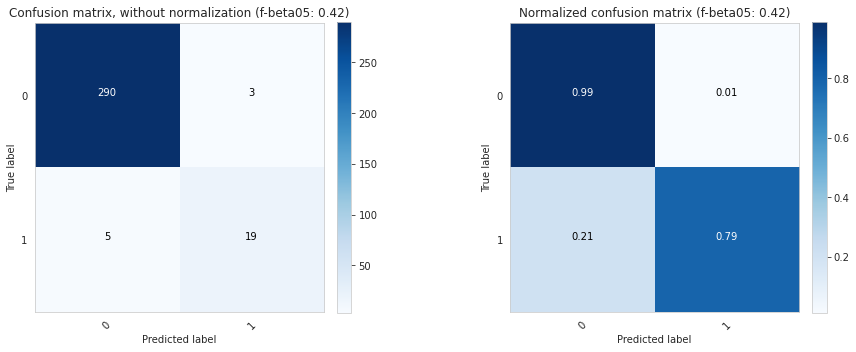

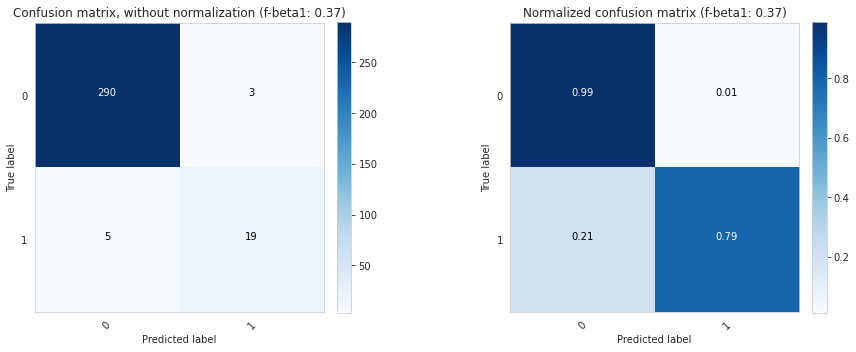

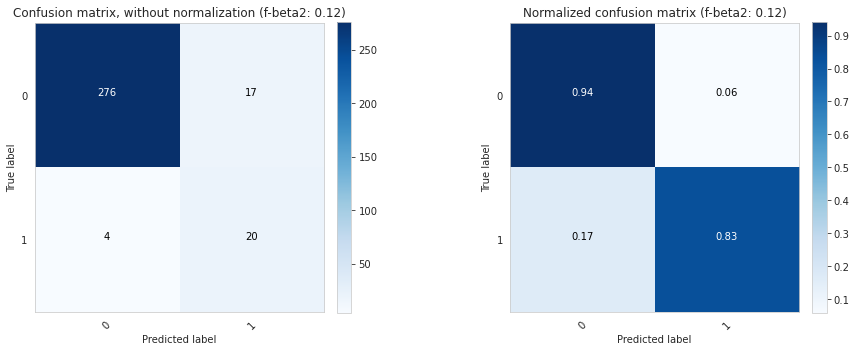



ROC Curve:


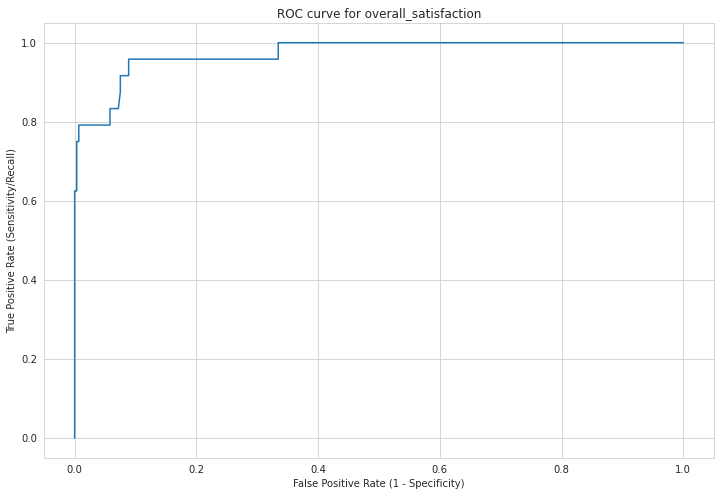

Predicted Probability Distribution:


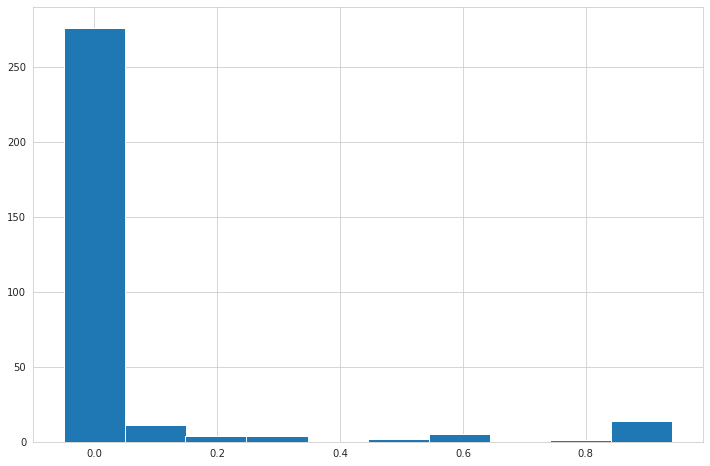



----------------------------------------------------------------------------------------------------


PROCESS_IMPROVEMENT

Null Accuracy:	0.9085173501577287
AUC Score:	0.8499161877394636

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9116719242902208	0.9148264984227129	0.8801261829652997	
Cohen's Kappa:	0.26291313735259914	0.33231921366721273	0.43620705794252546	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9248              0.9826              0.9529              288                 
1                   0.5455              0.2069              0.3                 29                  
avg/total           0.7351              0.5948              0.6264              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9307              0.9792              0.9543    

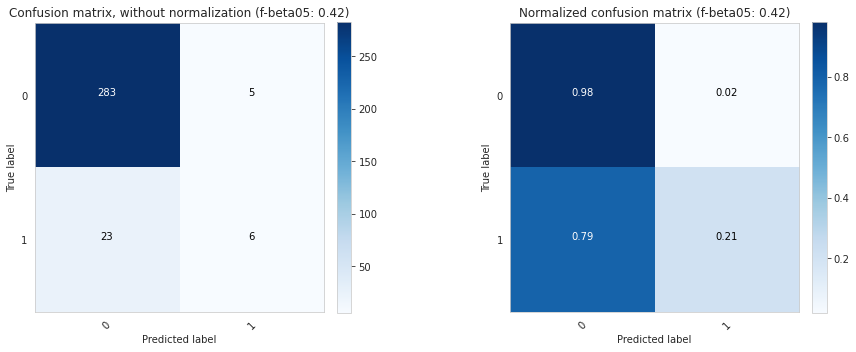

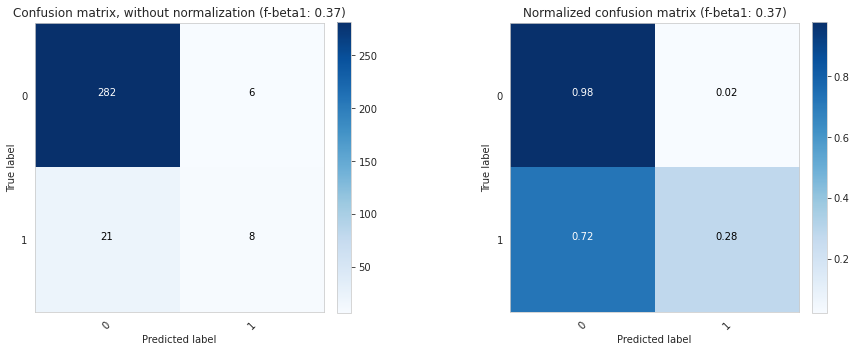

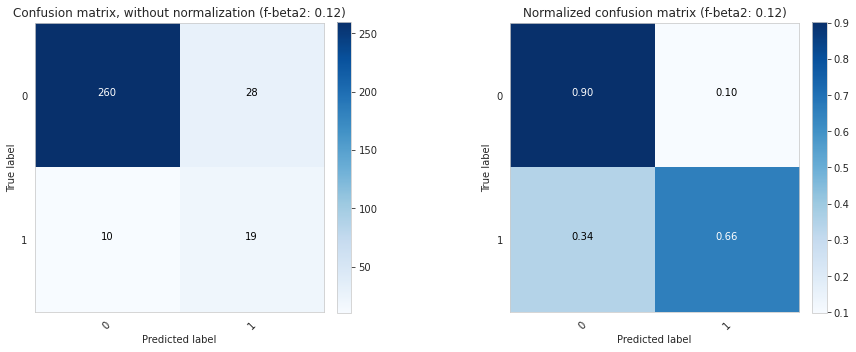



ROC Curve:


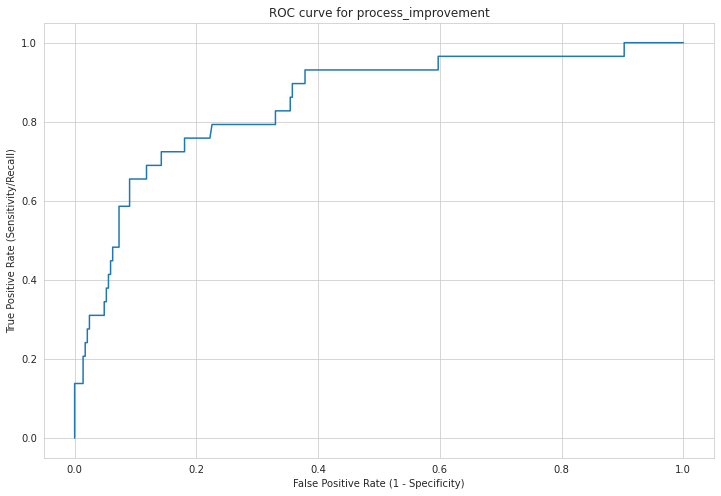

Predicted Probability Distribution:


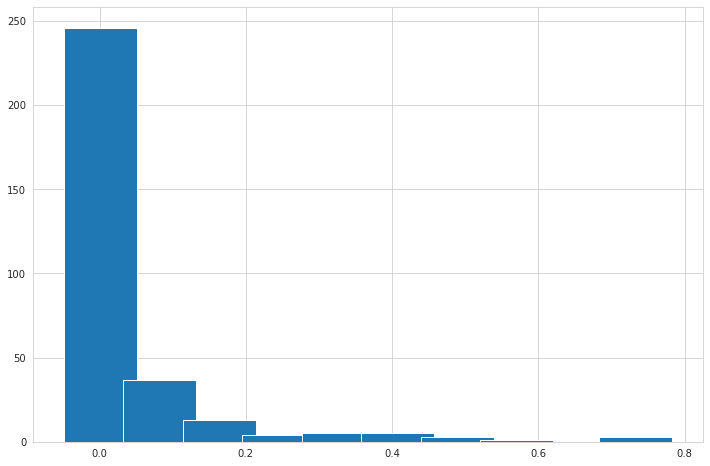



----------------------------------------------------------------------------------------------------


PROVIDES_EFFECTIVE_ADVICE_GUIDANCE

Null Accuracy:	0.9589905362776026
AUC Score:	0.8761386639676114

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9684542586750788	0.9621451104100947	0.9116719242902208	
Cohen's Kappa:	0.4852224748294901	0.4356083086053413	0.293312101910828	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9742              0.9934              0.9837              304                 
1                   0.7143              0.3846              0.5                 13                  
avg/total           0.8442              0.689               0.7419              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.974               0.9868             

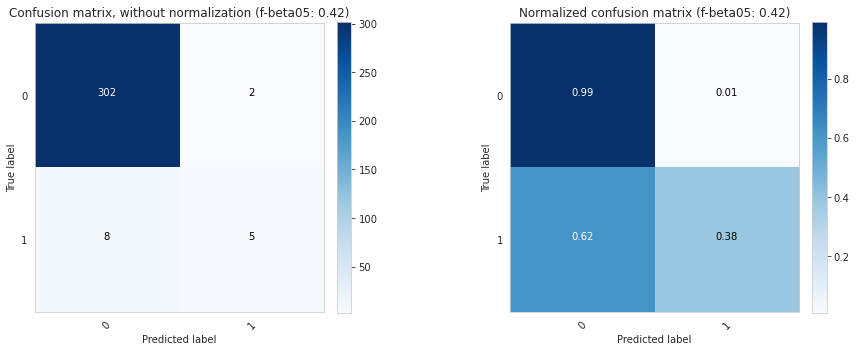

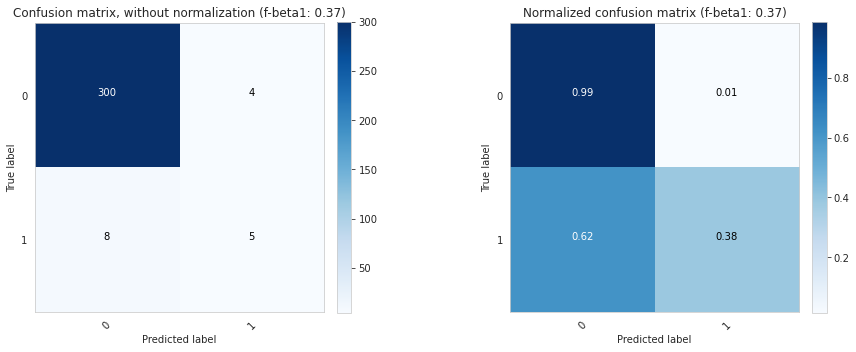

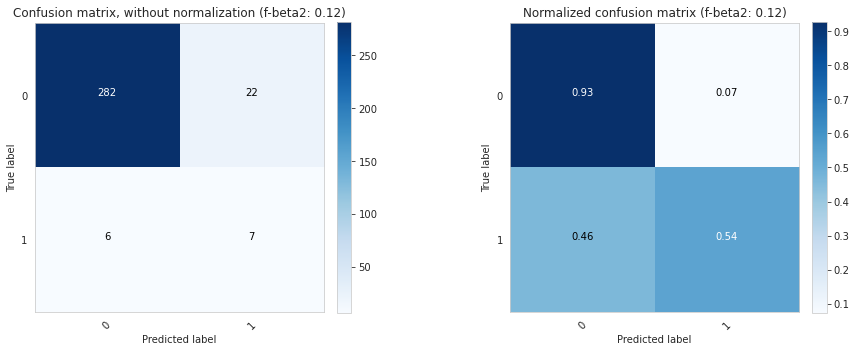



ROC Curve:


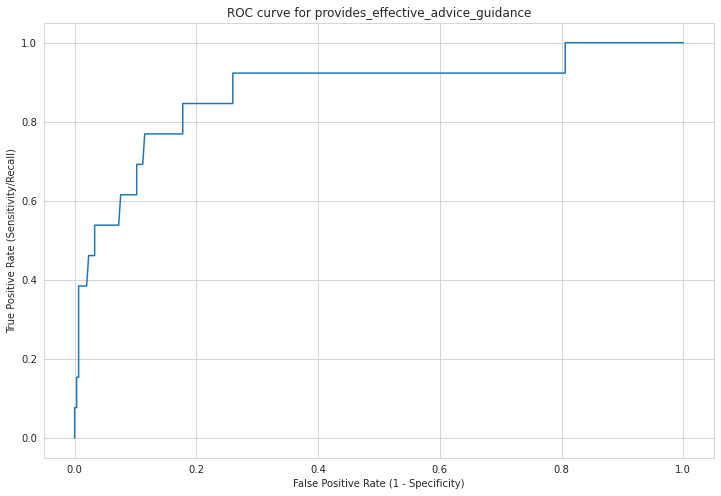

Predicted Probability Distribution:


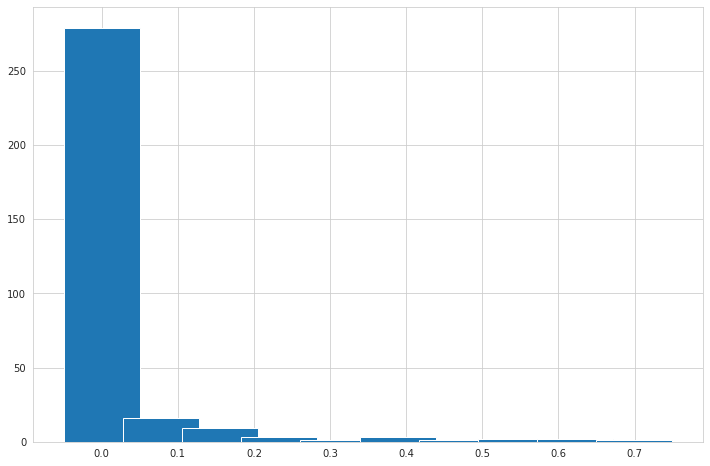



----------------------------------------------------------------------------------------------------


PROVIDES_TRAINING_ON_PROCESSES_APPLICATIONS

Null Accuracy:	0.9747634069400631
AUC Score:	0.9939320388349515

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9905362776025236	0.9873817034700315	0.9526813880126183	
Cohen's Kappa:	0.7646622123236823	0.743527508090615	0.49730415477323187	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9904              1.0                 0.9952              309                 
1                   1.0                 0.625               0.7692              8                   
avg/total           0.9952              0.8125              0.8822              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9935              0.9935   

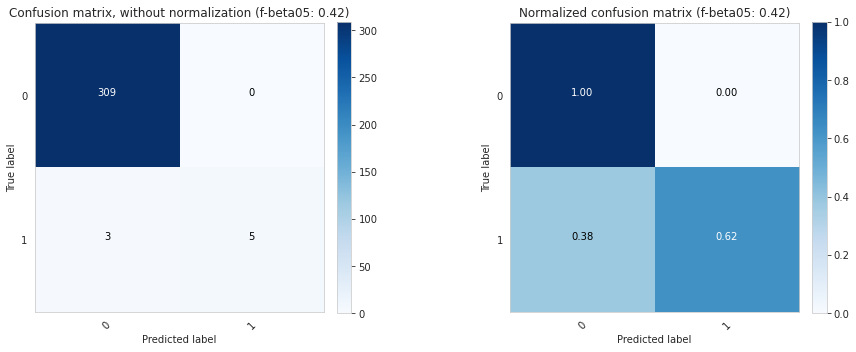

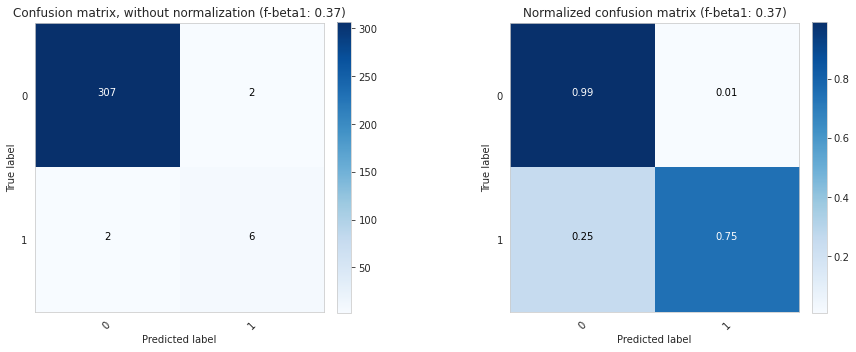

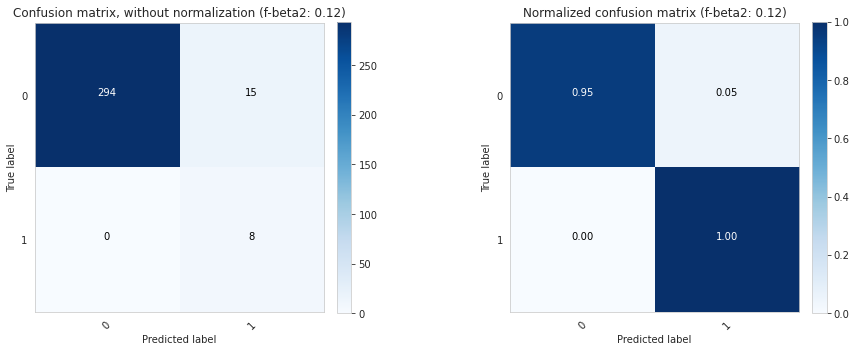



ROC Curve:


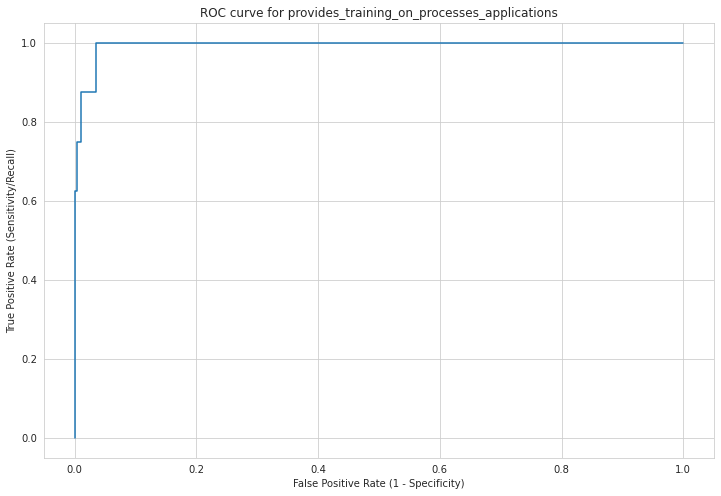

Predicted Probability Distribution:


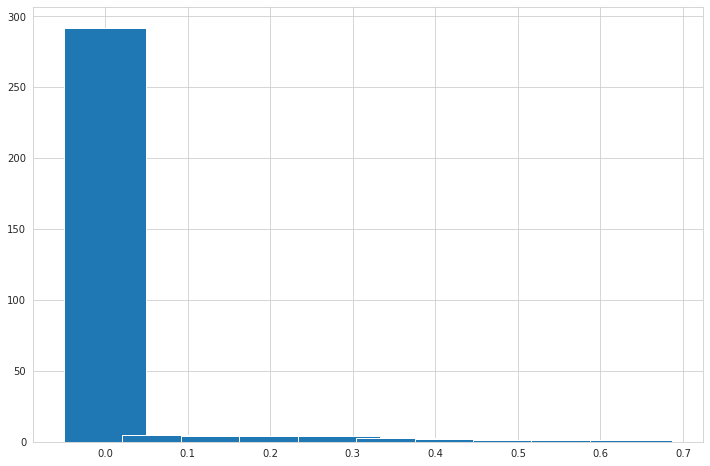



----------------------------------------------------------------------------------------------------


RESOLVES_PROBLEMS_EFFECTIVELY

Null Accuracy:	0.917981072555205
AUC Score:	0.8365054189796458

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9369085173501577	0.9337539432176656	0.8517350157728707	
Cohen's Kappa:	0.41792141020932805	0.4303927440746128	0.3152088982856093	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9414              0.9931              0.9666              291                 
1                   0.8                 0.3077              0.4444              26                  
avg/total           0.8707              0.6504              0.7055              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9441              0.9863              0.9

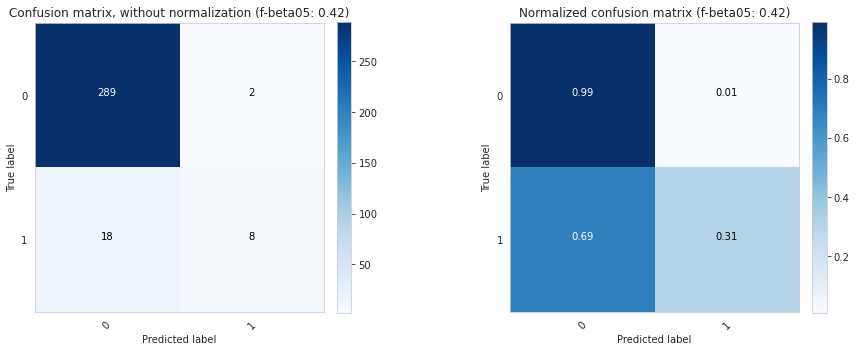

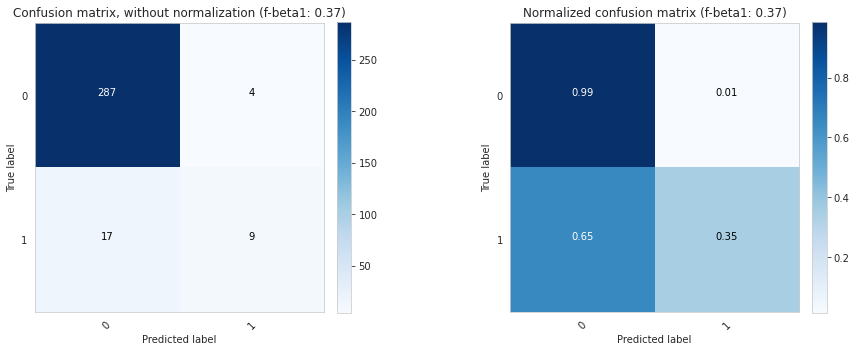

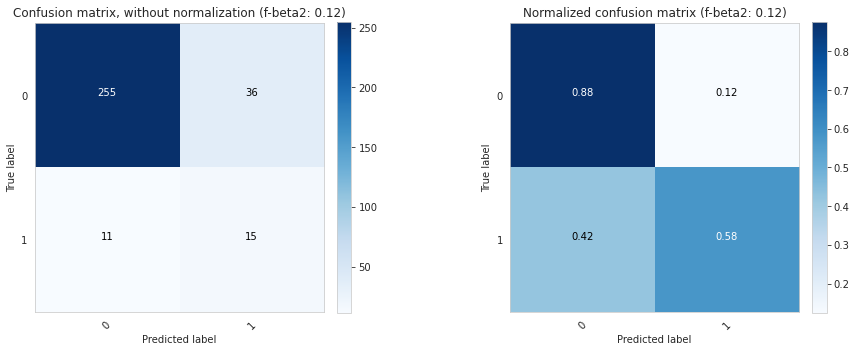



ROC Curve:


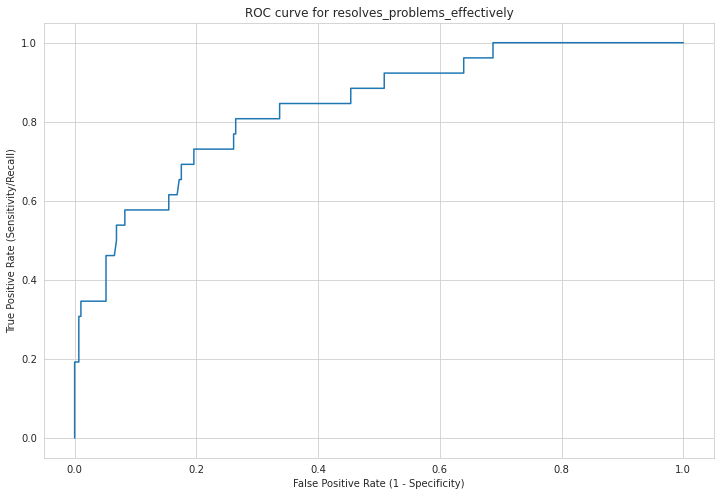

Predicted Probability Distribution:


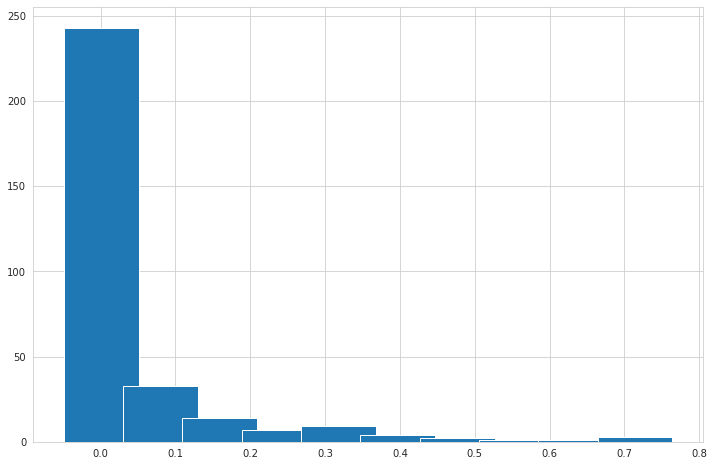



----------------------------------------------------------------------------------------------------


RESPONDS_TO_REQUESTS_WITHIN_AN_ACCEPTABLE_TIME

Null Accuracy:	0.8264984227129337
AUC Score:	0.9530534351145038

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.8990536277602523	0.9022082018927445	0.8485804416403786	
Cohen's Kappa:	0.6625640343290533	0.6753444117744227	0.5756595459869485	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9492              0.9275              0.9382              262                 
1                   0.6885              0.7636              0.7241              55                  
avg/total           0.8189              0.8456              0.8312              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9529              0.9275

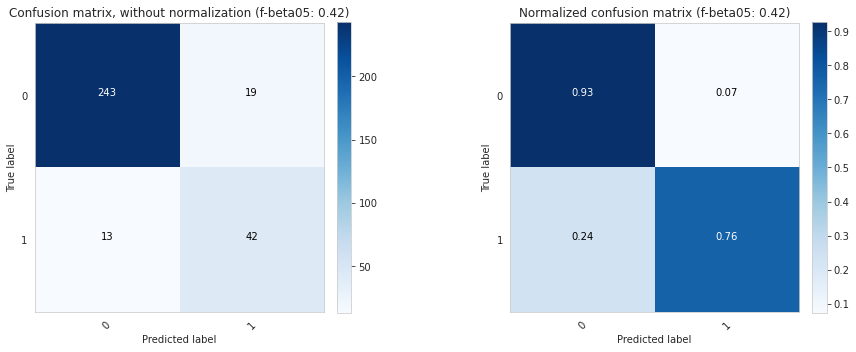

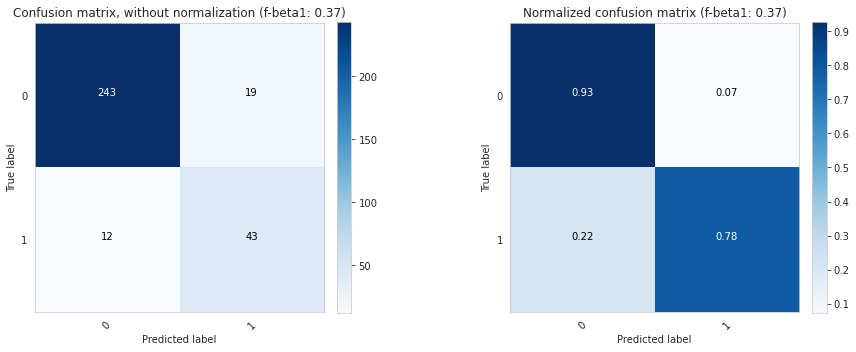

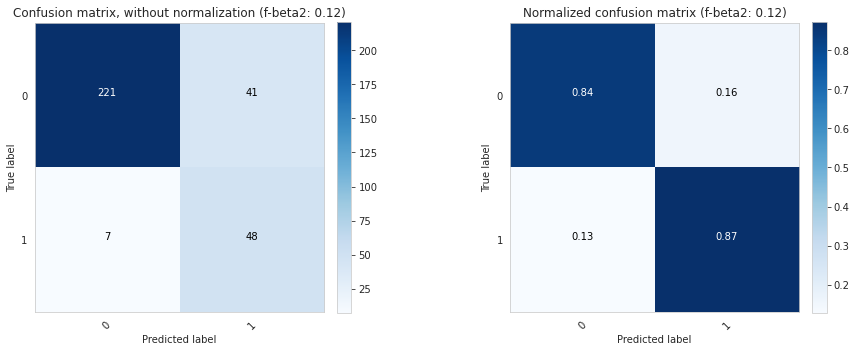



ROC Curve:


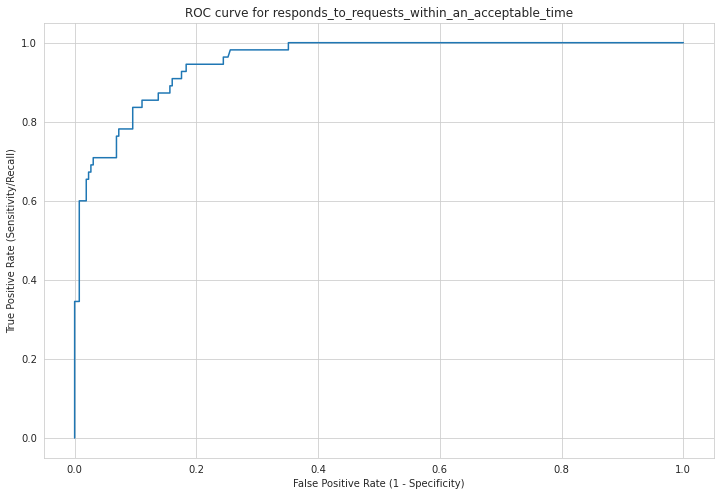

Predicted Probability Distribution:


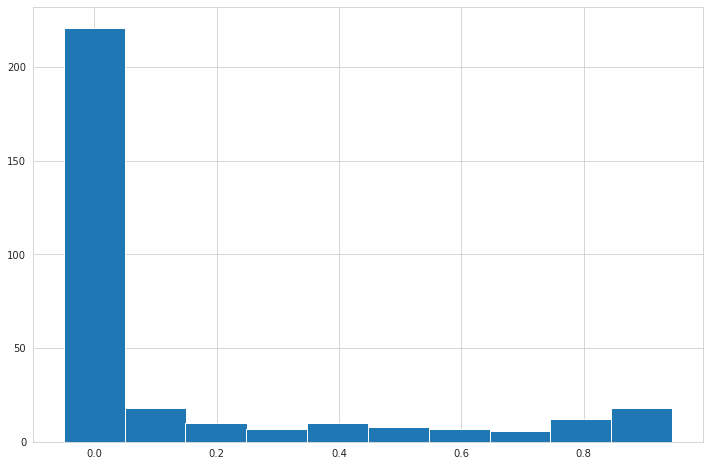



----------------------------------------------------------------------------------------------------


UNDERSTANDS_MY_NEEDS_AND_REQUIREMENTS

Null Accuracy:	0.9779179810725552
AUC Score:	0.7960829493087557

		f-beta05(0.42)		f-beta1(0.37)		f-beta2(0.12)
Accuracy:	0.9716088328075709	0.9716088328075709	0.9463722397476341	
Cohen's Kappa:	-0.009911504424778617	-0.009911504424778617	-0.026671746999428425	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9778              0.9935              0.9856              310                 
1                   0.0                 0.0                 0.0                 7                   
avg/total           0.4889              0.4968              0.4928              317                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9778              0.9935

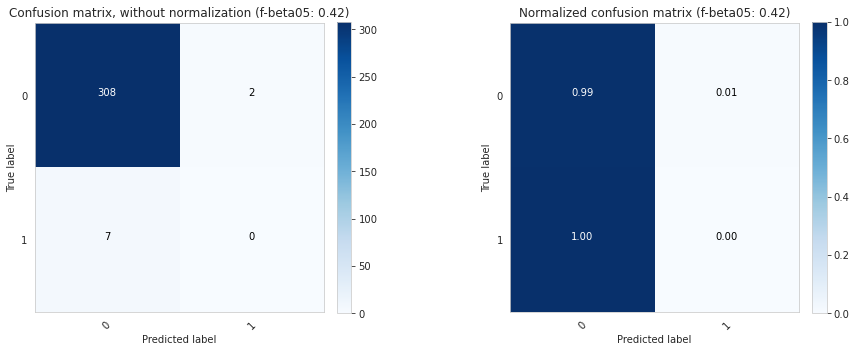

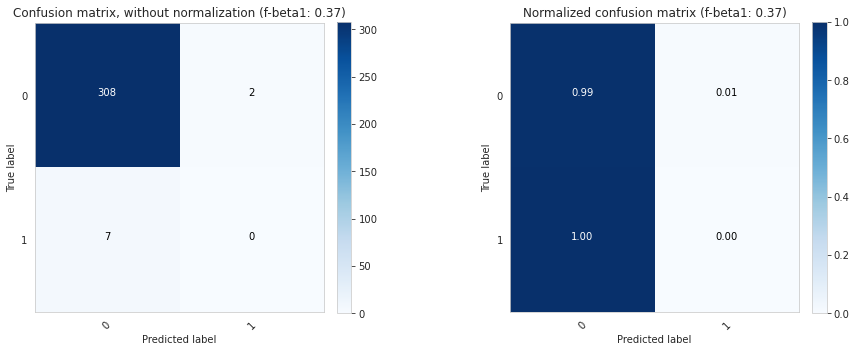

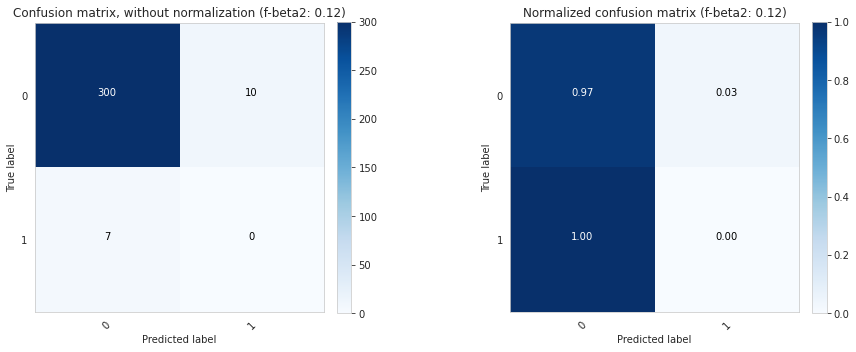



ROC Curve:


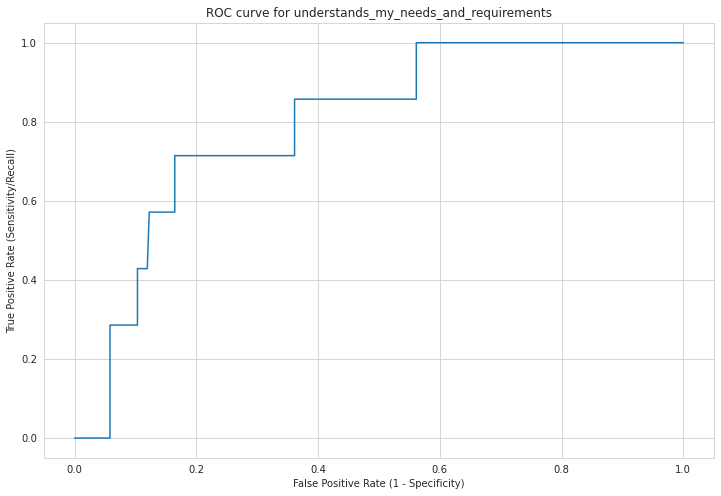

Predicted Probability Distribution:


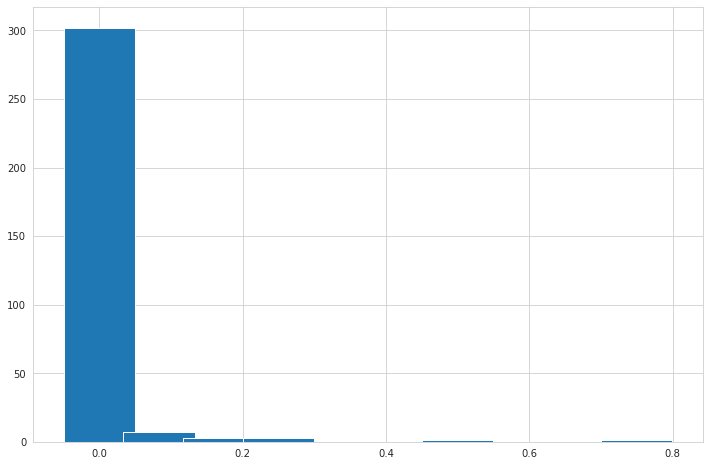



----------------------------------------------------------------------------------------------------




In [88]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Final results


In [89]:
#hide
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [90]:
inf_learn = load_learner(fname=f"{train_config['learner_path']}/exp_{train_config['export_filename']}")
inf_learn.loss_func.thresh = scores['opt_th']
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates={})
inf_learn.dls = dls

In [91]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [92]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

(torch.Size([317, 16]), torch.Size([317, 16]), torch.Size([317]))

In [93]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [94]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.4100000000000001 0.32000000000000006 0.14
Fowards Only
-------------
f05:	Optimal threshold = 0.4100000000000001	(Accuracy = 0.9469637274742126)
f1:	Optimal threshold = 0.32000000000000006	(Accuracy = 0.9422318339347839)
f2:	Optimal threshold = 0.14	(Accuracy = 0.9152207970619202)

Accuracy: 0.9469637274742126


In [95]:
final_valid_loss = loss.mean().item(); final_valid_loss

0.14356763660907745

## Build our training loop for hyperparam optimization and final training

In [96]:
#hide
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [97]:
#export
def train(params, trial=None, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'

    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    hf_config.num_labels = len(STANDARD_THEME_CSS_LABELS)
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)

    # 2. build our dls and learner
    df = get_train_data(train_config_updates=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config_updates=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
        
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]])))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        learn.loss_func.thresh = scores['opt_th']
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)

        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}

        scores['f05']['threshold'] = f05.opt_th(probs, targs)
        scores['f1']['threshold'] = f1.opt_th(probs, targs)
        scores['f2']['threshold'] = f2.opt_th(probs, targs)

        scores['f05']['score'] = f05.opt_fscore(probs, targs)
        scores['f1']['score'] = f1.opt_fscore(probs, targs)
        scores['f2']['score'] = f2.opt_fscore(probs, targs)

        # save scores from validation set if mode == training
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)

        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)

        probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS])
        targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in STANDARD_THEME_CSS_LABELS])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [98]:
#export
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [99]:
#export
def objective(trial, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 5),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 10),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 2e-4, 2e-2),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 3e-7, 3e-6),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 3e-8, 3e-7),
        'optimize_for': 'precision_score',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates)
    return score

In [100]:
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [101]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

train_config_updates = {}
study.optimize(partial(objective, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

[I 2021-03-06 13:32:47,225] A new study created in memory with name: no-name-a7fbf2c3-89d7-4d31-9fde-18078a21aa75


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.30100828086672704.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.5150966095011695.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.6103205012893181.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.6319121867404908.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.642376315462094.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 13:43:50,170] Trial 0 finished with value: 0.642376315462094 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 5, 'n_unfrozen_epochs': 9, 'frozen_lr': 0.00030067410779659756, 'unfrozen_lr_max': 8.650900162729e-07, 'unfrozen_lr_min': 9.689189223132957e-08, 'activation_dropout': 0.05, 'attention_dropout': 0.0, 'classif_dropout': 0.15000000000000002, 'dropout': 0.3, 'attention_probs_dropout_prob': 0.1, 'hidden_dropout_prob': 0.2}. Best is trial 0 with value: 0.642376315462094.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.4406164245398871.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.5707110851664755.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 13:51:11,304] Trial 1 finished with value: 0.5707110851664755 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 6, 'frozen_lr': 0.003749187086412521, 'unfrozen_lr_max': 1.9248016879732888e-06, 'unfrozen_lr_min': 1.5350351325922208e-07, 'activation_dropout': 0.3, 'attention_dropout': 0.1, 'classif_dropout': 0.25, 'dropout': 0.2, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.0}. Best is trial 0 with value: 0.642376315462094.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.29971389663660114.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.655916164979428.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 13:54:02,250] Trial 2 finished with value: 0.655916164979428 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 5, 'n_unfrozen_epochs': 0, 'frozen_lr': 0.0002262197449684347, 'unfrozen_lr_max': 1.5798853628474602e-06, 'unfrozen_lr_min': 4.044757645398285e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.3, 'classif_dropout': 0.1, 'dropout': 0.2, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.1}. Best is trial 2 with value: 0.655916164979428.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 13:56:47,752] Trial 3 finished with value: 0.6628509469961982 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 5, 'n_unfrozen_epochs': 0, 'frozen_lr': 0.00041214168922822444, 'unfrozen_lr_max': 1.1462248358779009e-06, 'unfrozen_lr_min': 4.811113243735234e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.2, 'classif_dropout': 0.2, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.15000000000000002, 'hidden_dropout_prob': 0.05}. Best is trial 3 with value: 0.6628509469961982.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:04:54,493] Trial 4 finished with value: 0.5475486276455027 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 7, 'frozen_lr': 0.00020287659696778193, 'unfrozen_lr_max': 1.0960944227270872e-06, 'unfrozen_lr_min': 2.0591811274311472e-07, 'activation_dropout': 0.0, 'attention_dropout': 0.2, 'classif_dropout': 0.3, 'dropout': 0.15000000000000002, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.15000000000000002}. Best is trial 3 with value: 0.6628509469961982.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.4807157763055068.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:07:28,193] Trial 5 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:09:58,119] Trial 6 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:11:10,947] Trial 7 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:13:43,300] Trial 8 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:14:24,965] Trial 9 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:15:06,392] Trial 10 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:15:47,319] Trial 11 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:16:58,840] Trial 12 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.526267387610875.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.5929047160128347.
Better model found at epoch 3 with precision_score value: 0.6469631579535993.


[I 2021-03-06 14:21:41,838] Trial 13 finished with value: 0.6469631579535993 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 5, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.0010612455130431988, 'unfrozen_lr_max': 2.433665380427492e-06, 'unfrozen_lr_min': 4.996252920785756e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.15000000000000002, 'classif_dropout': 0.2, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.1}. Best is trial 3 with value: 0.6628509469961982.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:22:23,725] Trial 14 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:23:36,221] Trial 15 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5200725692629069.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:24:49,232] Trial 16 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:27:03,084] Trial 17 pruned. Trial was pruned at epoch 3.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:27:44,595] Trial 18 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5024856098570238.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:28:58,345] Trial 19 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:29:39,930] Trial 20 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5012095713787921.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:30:53,288] Trial 21 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5235136940816005.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.634947472707397.
Better model found at epoch 2 with precision_score value: 0.648911792960542.


[I 2021-03-06 14:33:47,839] Trial 22 finished with value: 0.648911792960542 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 5, 'n_unfrozen_epochs': 0, 'frozen_lr': 0.0004933074570735375, 'unfrozen_lr_max': 2.201237314803215e-06, 'unfrozen_lr_min': 4.2631760886951926e-08, 'activation_dropout': 0.05, 'attention_dropout': 0.15000000000000002, 'classif_dropout': 0.25, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.1}. Best is trial 3 with value: 0.6628509469961982.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5214227014674895.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.5778778377419682.
Better model found at epoch 2 with precision_score value: 0.5904635338108224.


[I 2021-03-06 14:36:08,462] Trial 23 pruned. Trial was pruned at epoch 3.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.4917053286108458.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:37:23,638] Trial 24 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:38:05,200] Trial 25 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5440078136963542.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.5961851612203586.
Better model found at epoch 2 with precision_score value: 0.6050156444934428.
Better model found at epoch 3 with precision_score value: 0.6275239774007553.


[I 2021-03-06 14:43:44,564] Trial 26 finished with value: 0.6275239774007553 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 5, 'n_unfrozen_epochs': 3, 'frozen_lr': 0.0006024154274237775, 'unfrozen_lr_max': 1.4715802870649308e-06, 'unfrozen_lr_min': 6.299015226565535e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.1, 'classif_dropout': 0.1, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.1, 'hidden_dropout_prob': 0.05}. Best is trial 3 with value: 0.6628509469961982.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5156889374644451.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:44:58,972] Trial 27 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:45:40,653] Trial 28 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-06 14:46:21,664] Trial 29 pruned. Trial was pruned at epoch 0.


In [102]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"
   
pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['fbeta_score'] = study.best_value

with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  22
  Number of complete trials:  8
Best trial:
  Value:  0.6628509469961982
  Params: 
    pretrained_model_name: facebook/bart-base
    save_model: False
    use_weighted_loss: False
    use_fp16: True
    n_frozen_epochs: 5
    n_unfrozen_epochs: 0
    frozen_lr: 0.00041214168922822444
    unfrozen_lr_max: 1.1462248358779009e-06
    unfrozen_lr_min: 4.811113243735234e-08
    activation_dropout: 0.0
    attention_dropout: 0.2
    classif_dropout: 0.2
    dropout: 0.1
    attention_probs_dropout_prob: 0.15000000000000002
    hidden_dropout_prob: 0.05
  User attrs:
total time is 4414.655457 seconds


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/optuna/structs.py:18: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)


### Training with best params

In [103]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"

In [104]:
with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
train_yyyymmdd = datetime.today().strftime("%Y%m%d")
scores, train_res_df = train(params=best_params, yyyymmdd=train_yyyymmdd, train_config_updates={})

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
scores

{'valid_loss': 0.1384221762418747,
 'accuracy_multi': 0.9382886290550232,
 'fbeta_score': 0.6301702408610497,
 'precision_score': 0.5861728086477542,
 'recall_score': 0.6925,
 'roc_auc_score': 0.8195069292762297,
 'opt_th': 0.23999999999999994,
 'f05': {'threshold': 0.4800000000000001, 'score': 0.6526789780639173},
 'f1': {'threshold': 0.24000000000000005, 'score': 0.6301702408610497},
 'f2': {'threshold': 0.12000000000000001, 'score': 0.7041441474958571}}

In [106]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,accessible_to_customers,consistency_in_policies_information,cost_fees,courteous_professional_staff,effective_communications,effectively_uses_websites_online_documentation,helpful_staff,knowledgeable_staff,moving_in_a_positive_direction,overall_satisfaction,process_improvement,provides_effective_advice_guidance,provides_training_on_processes_applications,resolves_problems_effectively,responds_to_requests_within_an_acceptable_time,understands_my_needs_and_requirements,labels,is_valid,_text_,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,targ_accessible_to_customers,targ_consistency_in_policies_information,targ_cost_fees,targ_courteous_professional_staff,targ_effective_communications,targ_effectively_uses_websites_online_documentation,targ_helpful_staff,targ_knowledgeable_staff,targ_moving_in_a_positive_direction,targ_overall_satisfaction,targ_process_improvement,targ_provides_effective_advice_guidance,targ_provides_training_on_processes_applications,targ_resolves_problems_effectively,targ_responds_to_requests_within_an_acceptable_time,targ_understands_my_needs_and_requirements,loss
0,0,602983,38342,"In the past 1-2 years, the office changed their policy to only give international postdocs J1 vi...",NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,454199,ISPO,Let us know your suggestions on how to improve the International Students & Programs Office.,Verbatim-Dept-Improve,636.0,ISPO_Improve,International Students & Programs Office,Student,Global Education,International Program,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,consistency_in_policies_information,False,"In the past 1-2 years, the office changed their policy to only give international postdocs J1 vi...",0.010408,0.404507,0.046812,0.003286,0.020606,0.013584,0.026355,0.046378,0.029312,0.001008,0.446133,0.070688,0.024099,0.135690,0.004365,0.005775,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121923
1,1,597736,12605,"The custodians are kind and competent people. However, the unit, at least in the research buildi...",NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,454041,Custodial Services,Let us know your suggestions on how to improve Custodial Services.,Verbatim-Dept-Improve,140.0,Custodial_Improve,Custodial Services,Facilities,"Building, Custodial, Facilities Maintenance",Custodial Services,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,courteous_professional_staff,False,"The custodians are kind and competent people. However, the unit, at least in the research buildi...",0.006615,0.001860,0.033844,0.800692,0.000387,0.005598,0.198996,0.210442,0.003235,0.010902,0.007756,0.001688,0.003235,0.022629,0.203708,0.003594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063161
2,2,600057,12743,CUSTOMER SER

In [107]:
# load scores
with open(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_train_scores.json") as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.1384221762418747,
 'accuracy_multi': 0.9382886290550232,
 'fbeta_score': 0.6301702408610497,
 'precision_score': 0.5861728086477542,
 'recall_score': 0.6925,
 'roc_auc_score': 0.8195069292762297,
 'opt_th': 0.23999999999999994,
 'f05': {'threshold': 0.4800000000000001, 'score': 0.6526789780639173},
 'f1': {'threshold': 0.24000000000000005, 'score': 0.6301702408610497},
 'f2': {'threshold': 0.12000000000000001, 'score': 0.7041441474958571}}

In [108]:
inf_learn = load_learner(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_export.pkl")
inf_learn.loss_func.thresh = scores['opt_th']

print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.23999999999999994
[((['cost_fees'],), [tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False])], [tensor([1.7149e-02, 1.2075e-03, 4.6997e-01, 1.1741e-03, 4.2889e-03, 5.7324e-03,
        2.4736e-02, 3.2972e-03, 3.0818e-04, 1.2581e-01, 9.0598e-04, 5.1575e-03,
        6.6890e-03, 1.3531e-02, 7.5071e-03, 5.5205e-03])])]
[((['helpful_staff', 'overall_satisfaction'],), [tensor([False, False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False])], [tensor([0.0070, 0.0005, 0.0059, 0.0475, 0.0022, 0.0018, 0.4622, 0.0626, 0.0039,
        0.3577, 0.0027, 0.0035, 0.0090, 0.0026, 0.0034, 0.1089])])]


## Inference

### Inference (ad-hoc documents)

In [109]:
print(STANDARD_THEME_CSS_LABELS)

['accessible_to_customers', 'consistency_in_policies_information', 'cost_fees', 'courteous_professional_staff', 'effective_communications', 'effectively_uses_websites_online_documentation', 'helpful_staff', 'knowledgeable_staff', 'moving_in_a_positive_direction', 'overall_satisfaction', 'process_improvement', 'provides_effective_advice_guidance', 'provides_training_on_processes_applications', 'resolves_problems_effectively', 'responds_to_requests_within_an_acceptable_time', 'understands_my_needs_and_requirements']


In [110]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c))

[((['cost_fees'],), [tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False])], [tensor([6.4275e-03, 3.1572e-03, 7.9633e-01, 3.4529e-03, 3.5147e-03, 1.2421e-03,
        1.5753e-02, 2.8994e-03, 4.8416e-04, 4.8912e-02, 4.2927e-03, 2.4412e-03,
        3.7495e-03, 6.5421e-03, 2.5310e-02, 2.6377e-03])])]
[((['courteous_professional_staff', 'helpful_staff'],), [tensor([False, False, False,  True, False, False,  True, False, False, False,
        False, False, False, False, False, False])], [tensor([0.0026, 0.0021, 0.0036, 0.5170, 0.0008, 0.0041, 0.2549, 0.0224, 0.0017,
        0.0506, 0.0036, 0.0014, 0.0007, 0.0100, 0.0027, 0.0121])])]
[((['helpful_staff'],), [tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False])], [tensor([7.3129e-02, 5.2471e-04, 7.6206e-03, 5.9532e-02, 4.1385e-03, 1.9526e-03,
        5.5162e-01, 2.7049e-03, 1.2221e-03, 2.1962e-0

### Inference (batch)

In [111]:
#export
def get_preds(inf_df, yyyymmdd=None, learner_export_path=None, train_scores_path=None, 
              device=torch.device('cpu'), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    
    if (yyyymmdd is None and learner_export_path is None): 
        export_dir = Path(config['learner_path'])
        learner_export_path = sorted(export_dir.glob(f"[0-9]*_{config['export_filename']}"), reverse=True)[0]
        train_scores_path = export_dir/f"{learner_export_path.stem.split('_')[0]}_{full_model_name}_train_scores.json"
        
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
        
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.loss_func.thresh = training_results['opt_th']
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df = inf_df.copy()
    inf_df[config['txt_col']] = inf_df[config['orig_txt_col']]
    inf_df.dropna(subset=[config['txt_col']], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return results with scores in a df, probs, and labels
    prob_labels = ['prob_' + lbl for lbl in  STANDARD_THEME_CSS_LABELS]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    final_df.drop(columns=[config['txt_col']], inplace=True)
    
    for lbl in  STANDARD_THEME_CSS_LABELS:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['opt_th']).astype(np.int64)
        
#     final_df['valid_loss'] = training_results['valid_loss']
#     final_df['accuracy_multi'] = training_results['accuracy_multi']
#     final_df['fbeta_score'] = training_results['fbeta_score']
#     final_df['precision_score'] = training_results['precision_score']
#     final_df['recall_score'] = training_results['recall_score']
#     final_df['roc_auc_score'] = training_results['roc_auc_score']
#     final_df['opt_th'] = training_results['opt_th']
#     final_df['f05_threshold'] = training_results['f05']['threshold']
#     final_df['f05_score'] = training_results['f05']['score']
#     final_df['f1_threshold'] = training_results['f1']['threshold']
#     final_df['f1_score'] = training_results['f1']['score']
#     final_df['f2_threshold'] = training_results['f2']['threshold']
#     final_df['f2_score'] = training_results['f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, Path(learner_export_path).stem, training_results, STANDARD_THEME_CSS_LABELS

In [112]:
yyyymmdd = train_yyyymmdd

In [113]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)

print(len(verbatims_df), len(inf_df))

591447 4045


In [114]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, model_name, train_res, inf_labels = get_preds(inf_df, device=device, yyyymmdd=yyyymmdd, 
                                                        train_config_updates={'orig_txt_col': 'AnswerText'})
print(preds_df.shape, len(inf_labels))

cuda:1
0
(4045, 71) 16


In [115]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,_text_,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,pred_accessible_to_customers,pred_consistency_in_policies_information,pred_cost_fees,pred_courteous_professional_staff,pred_effective_communications,pred_effectively_uses_websites_online_documentation,pred_helpful_staff,pred_knowledgeable_staff,pred_moving_in_a_positive_direction,pred_overall_satisfaction,pred_process_improvement,pred_provides_effective_advice_guidance,pred_provides_training_on_processes_applications,pred_resolves_problems_effectively,pred_responds_to_requests_within_an_acceptable_time,pred_understands_my_needs_and_requirements
0,589996,2576,"no, I do not want to elaborate on my answers out fear of reprisal",NaN,English,212,9,SAW,UCSD,451417,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,17.0,3729,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,802.0,FACILITIES MANAGEMENT,17.0,FLEET SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"no, I do not want to elaborate on my answers out fear of reprisal",0.130440,0.017217,0.006780,0.005754,0.066446,0.014822,0.029563,0.012249,0.000293,0.009629,0.002577,0.196477,0.014464,0.022906,0.003576,0.002436,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,591624,9440,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,NaN,English,212,9,SAW,UCSD,449570,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,50712.0,4753,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,50100.0,"CAPITAL PROGRAM MANAGEMENT, DESIGN & DEVELOPMENT SERVICES",50710.0,CAPITAL PROGRAM MANAGEMENT,50712.0,CAPITAL PROGRAM MANAGEMENT STAFF,NaN,NaN,NaN,NaN,NaN,NaN,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,0.003654,0.029231,0.004969,0.187582,0.001090,0.005165,0.745116,0.102724,0.029300,0.013113,0.006091,0.033518,0.003047,0.106116,0.017108,0.464437,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,591691,9440,"Michelle Ghani, Medicine",NaN,English,212,9,SAW,UCSD,449814,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,90894.0,3321,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90894.0,REGENERATIVE MEDICINE,NaN,NaN,NaN,NaN,NaN,NaN,"Michelle Ghani, Medicine",0.036927,0.006601,0.009125,0.029800,0.004984,0.003540,0.067975,0.111382,0.018529,0.031777,0.006305,0.005225,0.006052,0.001865,0.041382,0.004309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,589378,1877,It has been said that we are paid accordingly to the market value of our counterparts in industr...,NaN,English,212,9,SAW,UCSD,451602,SAT,"If you would like to

## Cleanup

In [1]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_verbatims-sentiment.ipynb.
Converted 02a_verbatims-standard-themes-saw.ipynb.
Converted 02b_verbatims-standard-themes-css.ipynb.
Converted 02c_verbatims-standard-themes-meta.ipynb.
Converted 99_inference.ipynb.
Converted index.ipynb.


## Playground

In [117]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in STANDARD_THEME_CSS_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_CSS_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\r\n\r\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation.

=== preds ===
['pred_courteous_professional_staff', 'pred_helpful_staff', 'pred_knowledgeable_staff']

=== probs ===
[0.48708144, 0.5484615, 0.41233656]
